# Job skill recommender
#### Inputs skills and recommends which new ones to aquire in order to improve market value

<b>Key aim is to build an interactive tool that would accept user prompt of skills, seniority, desired category and then assess chances and recommend areas of development.</b>

Additonal aims:
- understand the relationship between skills and categories
- what are the meta-groups of key skills
- how many and which skills should the tool focus on (skill selection)
- understand the impact of seniority level on market chances and expected salary
- optimize the relation between expected salary and skill combination popularity (potential jobs to apply to)

## Libraries

Libraries required to the whole processing to work

In [1]:
# Import libraries 
import pandas as pd # Data processing
import numpy as np # Matrices, models
import random  # Random sampling

from scipy.cluster import hierarchy # Hierarchical clustering
from scipy.cluster.hierarchy import linkage, fcluster,dendrogram

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet # Models to screen
from sklearn.neighbors import KNeighborsRegressor # KNN algorithm
from sklearn.model_selection import cross_val_score # Cross validation
from sklearn.model_selection import GroupShuffleSplit # Library to perform group shuffle (by jobId)
from sklearn.tree import DecisionTreeRegressor # Single decision tree
from sklearn.svm import SVR # Support Vector Regressor
from sklearn.preprocessing import StandardScaler # mean=0 sd=1 standarization
from sklearn.feature_selection import SelectKBest, f_regression # Variable selection
from sklearn.metrics import mean_squared_error, r2_score # Model validation and testing
from sklearn.model_selection import GridSearchCV # Hyperparameter optimization
from sklearn.ensemble import RandomForestRegressor # Random Forest
from sklearn.ensemble import GradientBoostingRegressor # Main model
from sklearn.manifold import MDS # for MDS dimensionality reduction

import joblib # Model exports
from joblib import load
import pickle # to save a list of features

import matplotlib.pyplot as plt # Charts 
import matplotlib.ticker as mticker # Percent formatting of a histogram
import seaborn as sns # Charts
from adjustText import adjust_text # Label separation on a scatter plot

# Options
plt.style.use('fivethirtyeight') #
pd.options.display.max_columns = 50
pd.options.display.max_rows = 50

# Path to folder
path = '/Users/grzegorzpopielnicki/Documents/GitHub/job-skill-recommender/databases_csv/'


## Functions and classes

User-defined functions to improve flow of the code

### Functions

In [2]:
def import_and_prepare_job_data(path):
    '''
    imports flat files coming from MySQL and merges them into one compact dataset
    path - path to a folder with files
    '''
    factSkills = pd.read_csv(path+'factSkills.csv') #fact table with skills
    dimSkills = pd.read_csv(path+'dimSkills.csv') #dim skills (skill dictionary)
    masterdimJob = pd.read_csv(path+'masterdimJob.csv') # full information on job with fk's
    dimJobSeniority = pd.read_csv(path+'dimJobSeniority.csv') # full information on job with fk's
    dimCategories = pd.read_csv(path+'dimCategories.csv') # Categories
    # Merge skillAgr
    factSkills = factSkills.merge(dimSkills[['skillAgr','id']], 
                                  how='left', 
                                  left_on='fk_dimSkills', 
                                  right_on='id') # Merge agregated Skill
    # Merge salary information from job offer
    factSkills = factSkills.merge(masterdimJob[['jobId','salaryLow','salaryHigh','fk_dimJobSeniority','fk_dimCategories']],
                                 how ='left', 
                                 on='jobId')
    # Merge seniority level
    factSkills = factSkills.merge(dimJobSeniority,
                                 how='left', 
                                 left_on='fk_dimJobSeniority',
                                 right_on='id')
    
    factSkills = factSkills.merge(dimCategories,
                                  how='left',
                                  left_on='fk_dimCategories',
                                  right_on='id')
    
    factSkills = factSkills.dropna() # Drop incomplete job offers


    # Select only legitimate salaries
    factSkills = factSkills.query('salaryLow <= salaryHigh')


    # Remove spec categories and others, as they hold little value so aggregated
    factSkills = factSkills.query('skillAgr != "SPEC" and skillAgr !="OTHER" and \
                                  skillAgr != "NONE" and skillAgr!= "FRENCH" ') 
    
    factSkills = factSkills.drop(['id_x','id_y','jobSeniority'],axis=1) #Drop unused columns
    
    return factSkills

def clean_and_process_job_data(factSkills):
  
    # Calculate salary mean
    factSkills['salaryMean'] = (factSkills['salaryLow'] + factSkills['salaryHigh']) / 2

    factSkills = factSkills[['jobId','skillAgr','salaryMean','jobSeniorityCategories','jobCategoryAgr']]
    jobCategories = np.char.upper(factSkills['jobCategoryAgr'].unique().astype(str))

    factSkills = pd.melt(factSkills, id_vars=['jobId', 'salaryMean'],
                                         var_name='variable',
                                         value_name='value')
    factSkills = factSkills.drop_duplicates(keep='first') # Drop duplicates


    factSkills = factSkills.sort_values(by=['jobId','variable'])


    # Uppercase skillAGR
    factSkills['value'] = factSkills['value'].str.upper()
    factSkills = factSkills.query('value != "SPEC" and value !="OTHER" and \
                                  value != "NONE" ') 

    factSkills = factSkills.reset_index(drop=True)
    factSkills = factSkills[['jobId','value','salaryMean']]
    
    with open('jobCategories.pkl', 'wb') as file:
        pickle.dump(jobCategories, file)


    return factSkills, jobCategories

def dataset_split(factSkills,random_state=65):
    '''
    splits dataset into train, val and test. Test is exported to separate files, but not returned
    '''
    X = factSkills
    y = factSkills['salaryMean']
    
    group_splitter = GroupShuffleSplit(test_size=0.2, random_state=random_state) # Set up the shuffle split properties
    train_val_index, test_index = next(group_splitter.split(X,y,groups=X['jobId']))
    train_index, val_index = next(group_splitter
                                  .split(X.iloc[train_val_index],
                                        y.iloc[train_val_index],
                                        groups=X.iloc[train_val_index]['jobId']))
    X_train, X_val, X_test = X.iloc[train_index], X.iloc[val_index], X.iloc[test_index]
    y_train, y_val, y_test = y.iloc[train_index], y.iloc[val_index], y.iloc[test_index]
    
    X_test.to_pickle('X_test.pkl')
    y_test.to_pickle('y_test.pkl')

    return X_train, X_val, y_train, y_val

def trainval_merge(X_train,X_val,y_train,y_val):
    '''
    merges train and val dataset for EDA, but leaves test out to avoid data leak
    '''
    X = pd.concat([X_train,X_val], axis=0)
    y = pd.concat([y_train,y_val], axis=0)
    df = pd.concat([X, pd.DataFrame(y)], axis=1)
    df = df.loc[:, ~df.columns.duplicated()] # Remove duplicated column
    
    return df

def prepare_pivoted_dataSet(eda, cutoff=0.0):
    '''
    Perform sets of repetitive steps in orther to prepare and pivot skill database for further data analysis
    cutoff - minimum % penetration of skill to be kept in the database
    '''

    # Count skills and merge into dataframe
    counted_skills = pd.DataFrame(eda.groupby('value').size())
    counted_skills.columns = ['occurenceCount']
    eda = eda.merge(counted_skills, 
                    how='left', 
                    left_on='value', 
                    right_on=counted_skills.index)

    # Number of analyzed job offers (in train+val)
    numberofJobOffers = eda[['jobId']].groupby(['jobId']) \
    .jobId.nunique().sum() # Count number of job offers
    eda['occurenceFreq'] = eda['occurenceCount'] / numberofJobOffers

    # Subset to cutoff
    eda = eda.query(' occurenceFreq >= @cutoff ')
    eda = eda[~eda['value'].str.startswith('LANG')] # Remove language-related requirements
    
    # Prepare a pivot version
    eda_pivot = eda.pivot_table(index='jobId',
                           columns='value',
                           values='salaryMean',
                           aggfunc='max',
                           fill_value=0)
    
    # get salaryMean into one column
    salaryMean = eda_pivot.max(axis=1)

    # Convert salaries to 1 (as in skill is present in the given job)
    eda_pivot01 = eda_pivot.mask(eda_pivot > 0,1)
    
    seniority_levels = [
        '1. TRAINEE',
        '2. TRAINEE-JUNIOR',
        '3. JUNIOR',
        '4. JUNIOR-MID',
        '5. MID',
        '6. MID-SENIOR',
        '7. SENIOR',
        '8. SENIOR-EXPERT',
        '9. EXPERT']
    

    choices_mapping = {
        '1. TRAINEE': 1,
        '2. TRAINEE-JUNIOR': 2,
        '3. JUNIOR': 3,
        '4. JUNIOR-MID': 4,
        '5. MID': 5,  # Adjusted numbering to skip the missing "4. JUNIOR-MID"
        '6. MID-SENIOR': 6,
        '7. SENIOR': 7,
        '8. SENIOR-EXPERT': 8,
        '9. EXPERT': 9
    }
    


    conditions = []
    choices = []
    
    for item in seniority_levels:
        if item in eda_pivot01.columns:
            conditions.append(eda_pivot01[item] == 1)
            choices.append(item)
    

    #choices_mapping = {item: index + 1 for index, item in enumerate(choices)}
    eda_pivot01['jobSeniorityNum'] = np.select(conditions, [choices_mapping.get(item) for item in choices], default=None)

    seniority_levels_df = pd.DataFrame({'seniority_level': seniority_levels})
    seniority_levels_df['jobSeniorityNum'] = seniority_levels_df['seniority_level'].str.extract(r'(\d+)',expand=False)
    seniority_levels_df['jobSeniorityNum'] = pd.to_numeric(seniority_levels_df['jobSeniorityNum'])
    
    # Remove unecessary columns
    
    eda_pivot01 = eda_pivot01.drop(columns=seniority_levels,errors='ignore')
    
    return eda_pivot01, salaryMean, seniority_levels_df

def split_pivotted_data(factSkills_pivot, salaryMean, X_train, X_val,X_test):
    '''
    splits pivotted data to reflect examply same ids as data split by entry variables
    '''
    
    factSkills_pivot_train =  factSkills_pivot[factSkills_pivot.index.isin(X_train['jobId'])]
    salaryMean_train =  salaryMean[salaryMean.index.isin(X_train['jobId'])]

    factSkills_pivot_val =  factSkills_pivot[factSkills_pivot.index.isin(X_val['jobId'])]
    salaryMean_val =  salaryMean[salaryMean.index.isin(X_val['jobId'])]

    factSkills_pivot_test =  factSkills_pivot[factSkills_pivot.index.isin(X_test['jobId'])]
    salaryMean_test =  salaryMean[salaryMean.index.isin(X_test['jobId'])]

    return factSkills_pivot_train, factSkills_pivot_val, factSkills_pivot_test, \
    salaryMean_train, salaryMean_val, salaryMean_test

def t1_trim_total_salary_range(df,salaryMean, lower, upper):
    '''
    1st transformation. Trims salaray to lower and upper bound based on hist analysis
    '''
    filtered_df = df.query(' @salaryMean >= @lower and @salaryMean <= @upper ')
    filtered_salaryMean = salaryMean[(salaryMean >= lower) & (salaryMean <= upper )]
    return filtered_df, filtered_salaryMean

def t2_trim_salary_per_seniority(df,salaryMean,lower_upper_bounds):
    '''
    2nd transformation - trims outliers based on job categories
    '''
    current_number_of_rows = len(df)
    df = df.merge(lower_upper_bounds, 
                    how='left', 
                    left_on='jobSeniorityNum',
                    right_index=True)

    filtered_df = df.query('@salaryMean.values >= lower_bounds and @salaryMean.values <= upper_bounds')
    filtered_salaryMean = salaryMean[(salaryMean > df['lower_bounds'].values) & (salaryMean < df['upper_bounds'].values)]
    filtered_df = filtered_df.drop(columns=['lower_bounds','upper_bounds'],axis=1)
    
    print (f'{current_number_of_rows-len(filtered_df)} rows removed')
    
    return filtered_df, filtered_salaryMean

def recode_categories_to_segments(df, categoriesAgr):
    '''
    Adds category segment columns to a df object
    '''
    # SEG 1: DESIGN / MOBILE
    df['cat: DESIGN MOBILE'] = np.where(
        (categoriesAgr == 'DESIGN') | 
        (categoriesAgr == 'MOBILE'),
        1,0
    )

    # SEG2: IT SUPPORT, ADMIN, SECURITY
    df['cat: IT ADMIN SUPPORT SECURITY'] = np.where(
        (categoriesAgr == 'SECURITY') | 
        (categoriesAgr == 'IT ADMINISTRATOR') | 
        (categoriesAgr == 'IT SUPPORT')
        ,1,0
    )

    # SEG3: MARKETING
    df['cat: MARKETING'] = np.where(
        (categoriesAgr == 'MARKETING'),
        1,0
    )

    # SEG4: AGILE / TESTING
    df['cat: AGILE TESTING'] = np.where(
        (categoriesAgr == 'AGILE') |
        (categoriesAgr == 'TESTING')    
        ,1,0
    )

    # SEG5: GAME DEV
    df['cat: GAME DEV'] = np.where(
        (categoriesAgr == 'GAME DEV'),
        1,0
    )

    # SEG6: BACKOFFICE / HR / SALES
    df['cat: BACKOFFICE HR SALES'] = np.where(
        (categoriesAgr == 'BACKOFFICE') |
        (categoriesAgr == 'HR') |
        (categoriesAgr == 'SALES')
        ,1,0
    )

    # SEG7: EMBEDDED / ERP
    df['cat: EMBEDDED ERP'] = np.where(
        (categoriesAgr == 'EMBEDDED') |
        (categoriesAgr == 'ERP') |
        (categoriesAgr == 'INNE')
        ,1,0
    )

    # SEG8: BI AI BIG DAGA
    df['cat: BI BIG DATA AI'] = np.where(
        (categoriesAgr == 'BUSINESS INTELLIGENCE') |
        (categoriesAgr == 'BIG DATA') |
        (categoriesAgr == 'AI')
        ,1,0
    )

    # SEG9:  DEVOPS
    df['cat: DEV OPS'] = np.where(
        (categoriesAgr == 'DEVOPS')
        ,1,0
    )

    # SEGM 10: DEVELOPMENT
    df['cat: DEVELOPMENT'] = np.where(
        (categoriesAgr == 'FRONTEND') |
        (categoriesAgr == 'ARCHITECTURE') |
        (categoriesAgr == 'BACKEND') |
        (categoriesAgr == 'FULLSTACK')
        ,1,0
    )

    # SEGM 11: PROJECT MANAGER
    df['cat: BA PROD PROJECT MANAGER'] = np.where(
        (categoriesAgr == 'BUSINESS ANALYSIS') |
        (categoriesAgr == 'PROJECT MANAGER') |
        (categoriesAgr == 'PRODUCT MANAGEMENT')
        ,1,0
    )
    return df

def drop_insignificant_columns(df, cutoff,skills_only=True):
    '''
    Drops skill columns for which frequencies are lower than cutoff.
    Usable for wide format
    '''
    column_sum = df.sum()
    column_count = df.count()

    column_avg = column_sum / column_count

    cols_to_drop = []
    for column in df.columns:
        if (column_avg[column] < cutoff) and (not column.startswith('cat')) and (column != 'jobSeniorityNum'):
            cols_to_drop.append(column)
        if skills_only and (column.startswith('cat') or column=='jobSeniorityNum'):
            cols_to_drop.append(column)


    df = df.drop(cols_to_drop, axis=1)
    return df

def train_val_split(X_trainval, y_trainval, random_state=99, split_size=0.2):
    '''
    Performs an ad hoc train val split for validation purposes
    '''
    indices = np.arange(len(X_trainval))
    train_indices, val_indices = train_test_split(indices, test_size=split_size,
                                                  random_state=random_state)
    X_train = X_trainval.iloc[train_indices]
    X_val = X_trainval.iloc[val_indices]
    y_train = y_trainval.iloc[train_indices]
    y_val = y_trainval.iloc[val_indices]

    return X_train, X_val, y_train, y_val
    
def single_column_categories(df):
    '''
    Takes all the categories columns and creates a pd series based on them.
    '''
    categoriesAgr = df.apply(
        lambda row: df.columns[row == 1][0] if any(row == 1) else None, axis=1
    )
    return categoriesAgr

def tree_tuning(estimator,df,X_train_scaled, y_train, param_grid,random_state=10, verbose=2, scoring='r2', cv=5):

    '''
    Take param grid as as input and returns grid searched result
    '''
    model = None
    if estimator == 'gbr':
        model = GradientBoostingRegressor(random_state=random_state) # Initialize the model class
    else:
        model = RandomForestRegressor(random_state=random_state)

    grid_search = GridSearchCV(estimator=model, 
                            param_grid=param_grid,
                            cv=cv,
                            scoring=scoring,
                            verbose=verbose)
    grid_search.fit(X_train_scaled, y_train)

    best_params = grid_search.best_params_ #best parameters
    best_score = grid_search.best_score_ # R2
    print(best_params, best_score) # Acceptable R2 for relatively low correlation situation

    # Feature importances
    feature_importances = grid_search.best_estimator_.feature_importances_
    sorted_indices = np.argsort(feature_importances)[::-1]
    sorted_importances = feature_importances[sorted_indices]
    feature_names = df.columns[sorted_indices]

    plt.figure(figsize=(10,6))
    plt.bar(range(len(feature_importances)),sorted_importances,align='center')
    plt.xticks(range(len(feature_importances)),feature_names, rotation='vertical', fontsize=10)
    plt.xlim(-0.5, 29.5)
    plt.ylabel('Feature importance: Top 30 features')
    plt.xlabel('Feature')
    plt.title('Variable importance')
    plt.show()


    return grid_search

### Classes

class that is responsible for building job recommendations

In [3]:
class JobSkillRecommender():
    def __init__(self, df, 
                 model = None, 
                 scaler = None,
                 job_categories = None,
                 selected_category = None):
        self.df = df # Data frame
        ## CALCULATE STARTING SIZE OF JOB DF
        self.model = model # Model
        self.scaler = scaler # Standard scaler
        self.job_categories = pd.DataFrame({'job_categories': job_categories})
        # If single category analysis, perform df subsettting
        if selected_category:
            # Trim the job data to only selected categories
            self.job_categories = self.job_categories[self.job_categories['job_categories'].isin(selected_category)]

            # Perform similar selection on skill df
            self.df = self.df.loc[self.job_categories.index]
        # Skills separate dataset

        self.numberOfJobs = len(self.df) # Number of jobs (denominator)

        
    def calculateReach(self,usr_skills):
        '''
        Calculates reach based on input skill
        Reach = (number of fitting jobs) / (total number of jobs)
        '''
        # Subset db of other skills
        oth_skills_df = self.df_matched.drop(columns=usr_skills) # Keep other skills
        
        # Subset db of user skills
        usr_skills_df = self.df_matched[usr_skills] # Keep these skills

        # Sum of needed other skills
        c2_other_skills = oth_skills_df.sum(axis=1) # How many other skills needed
        
        # Sum of needed user skills
        c2_matched_skills = usr_skills_df.sum(axis=1) # How many owned skills needed

        # If matched skills > other skills, we assume job fits the user
        
        rch = sum(c2_matched_skills > c2_other_skills) / self.numberOfJobs
        return rch
    
    def get_expected_salary(self, user_seniority, user_skills):
        '''
        Accepts seniority level and user skills to predict expected salary
        '''
      
        input_values = {} #Empty dict
          
        # user seniority (values 1 to 9)
        input_values['jobSeniorityNum'] = [user_seniority]
        
        # for every skill in user_skills, add to dictionary and assign 1
        for skill in user_skills:
            input_values[skill] = [1]
            
        # every col in df, if col is not present in input values, assign 0 to it
        for col in self.df.columns:
            if col not in input_values:
                input_values[col] = 0

        # build tmp_df as 1-row df
        tmp_df = pd.DataFrame(input_values)
        tmp_df = tmp_df.sort_index(axis=1)
        #tmp_df = tmp_df[self.skills_shortlist] 
        # tmp_df = tmp_df.values
        new_data_scaled = self.scaler.transform(tmp_df)
        input_predict = self.model.predict(new_data_scaled)
        return round(input_predict[0],2)

    def predict_skill_impact_on_salary(self):
        '''
        predicts unit skill impact on salary and returns a data frame
        '''
        skills = [] # Empty skills array
        salaries = [] # Emmpty salary array
        
        # For every skill in df (without seniority level)
        for skill in self.df.drop(['jobSeniorityNum'],axis=1).columns:
            skills.append(skill) # Add skill to analysis
            # Use method to calculate the salary for this only skill
            salaries.append(self.get_expected_salary(self.user_seniority,
                                                  [skill]))
        
        # Obtain a df
        skill_salaries_df = pd.DataFrame({'skill':skills,
                                         'salary': salaries})

        return skill_salaries_df
    
    def gatherUserInput(self, user_seniority, user_skills):
        '''
        Gets users' input (seniority and jobs).
        Calculates starting reach and salary (if with model)
        '''
        # Assign values to user seniority and skills
        self.user_seniority = user_seniority 
        self.user_skills = user_skills
        
        # Condition 1 - job seniority must be equal or lower
        self.df_matched = self.df.query(' jobSeniorityNum <= @user_seniority')
        self.df_matched = self.df_matched.drop(columns=['jobSeniorityNum'])
        
        # Assign user skills and obtain remanining skills
        self.other_skills_df = self.df_matched.drop(columns=user_skills)
        self.user_skills_df = self.df_matched[user_skills]
        
        # Calculate starting reach
        self.starting_reach = self.calculateReach(self.user_skills)
        self.reach = self.starting_reach
        
        print(f'Starting reach: {self.starting_reach}')
        print(f'Starting salary: {self.get_expected_salary(self.user_seniority,self.user_skills)}')
        
    def print_reach(self):
        '''
        Prints reach of the current reach calculation
        '''
        print(f'Reach = {round(self.rch*100,1)}%')
        
    def findNextSkill(self):
        '''
        Checks all the other skills. 
        Returns a data frame with the ones that deliver highest reach incremental
        '''
        # N+1 skill browser
        # Starting reach array
        reach_array = [self.starting_reach] # Starting reach
        salary_array = [self.get_expected_salary(self.user_seniority,self.user_skills)]
        
        # Starting jobs array
        jobs_array = ['your_jobs']
        
        # For every item in other items' columns
        for i in self.other_skills_df.columns:
            # Append for new skill
            user_skills_new = self.user_skills + [i]
            # Calculate reach and expected salary for extended skillset
            reach = self.calculateReach(user_skills_new)
            salary = self.get_expected_salary(self.user_seniority,user_skills_new)

            # Append corresponding arrays
            reach_array = reach_array + [reach]
            jobs_array = jobs_array + [i]
            salary_array = salary_array + [salary]

        # Build a data frame
        jobs_reach_df = pd.DataFrame({"job": jobs_array, 
                                      "reach": reach_array,
                                     "salary": salary_array})
        
        # Calculate incremental against the base scenario
        jobs_reach_df['incremental'] = jobs_reach_df['reach'] - jobs_reach_df.loc[0, 'reach']
        
        # Leave out only skills that deliver any incremental
        jobs_reach_df = jobs_reach_df.query('incremental > 0 ')
        jobs_reach_df = jobs_reach_df.reset_index(drop=True)
        # Charting
        fig = plt.figure(figsize=(10,10))
        
        # Ensure optimal layout to many points
        plt.tight_layout()
        
        # Run a scatter method
        plt.scatter(jobs_reach_df['reach'], jobs_reach_df['salary'],alpha=0.5)
        
        # Fetch texts to labels
        texts = [] 
        for i, label in enumerate(jobs_reach_df['job']):
            texts.append(plt.text(jobs_reach_df['reach'][i], 
                                  jobs_reach_df['salary'][i],
                                  label, fontsize=8))
        adjust_text(texts)
        
        # Other formatting
        plt.xlabel('Reach after skill is introduced')
        plt.ylabel('Expected salary after skill is introduced')
        plt.grid(False)

        plt.show()
        
        # Return a table of most optimal jobs to add to the current skill set
        return jobs_reach_df.sort_values(by='reach',ascending=False)
          
    def careerPath(self,max_portfolio_size=30):
        '''
        Finds optimal in terms of reach building career path, 
        by adding one skill after another which are most optimal at the given stop
        max_portfolio_size (int) - maximum number of skills to be added to portfolio (default 30)
        '''
        
        check = 0 # Start checker at 0
        
        # Starting jobs array
        jobs_array = self.user_skills
        
        # Starting reach array
        reach_array = [self.starting_reach]*len(jobs_array) # Starting reach
        
        # While there are other skills to investigate and iteration is below max size
        while len(self.other_skills_df.columns)>0 and check <= max_portfolio_size:
            # Number of iterations = skills left to analyse
            tmp_reach = 0 # Set starting reach to 0
            tmp_index = None # Set index to none
            
            # For every i and skill column in dataframe columns
            for i, skill_column in enumerate(self.other_skills_df.columns):
                user_skills_new = self.user_skills + [skill_column]
                
                # Get Reach
                r = self.calculateReach(user_skills_new)
                
                # If reach greater than value stored so far, replace it
                if r > 0 and r > tmp_reach:
                    tmp_reach = r
                    tmp_index = i
            
            # If tmp_index is negative, stop the loop
            if tmp_index == -1:
                break
            
            # Assign the most optimal result to the user array
            self.user_skills = self.user_skills + [self.other_skills_df.columns[tmp_index]]
            job_array = jobs_array + [self.other_skills_df.columns[tmp_index]]
            reach_array = reach_array + [tmp_reach]                        
            self.other_skills_df = self.other_skills_df.drop(self.other_skills_df.columns[tmp_index], axis=1)

            # Go to the next skill to be added if there is still room
            check += + 1 # Increment check
        
        # Build a dataframe out of skills and reach
        jobs_reach_df = pd.DataFrame({"skill": self.user_skills, "reach": reach_array})
        # Calculate incremental
        jobs_reach_df['incremental'] = jobs_reach_df['reach'].diff().fillna(0)
        
        # PLOTTING OF REACH AND INCREMENTAL
        # Set up a bigg plot area and tight layout
        fig = plt.figure(figsize=(10,6))
        plt.tight_layout()
        
        # Add line plot to reflect reach frowth
        sns.lineplot(x='skill', y='reach', data=jobs_reach_df, color='blue')
        # Add barplot to reflect incremental at the given step
        sns.barplot(x='skill',y='incremental',data=jobs_reach_df,color='green')

        # Get skill names as labels, rotate vertically
        plt.xticks(jobs_reach_df.index,'+' + jobs_reach_df['skill'])
        plt.xticks(rotation='vertical')
        
        # Further formatting
        plt.title('Optimal order of skill development')
        plt.xlabel('+Skill -->')
        plt.ylabel('% of jobs qualified / incremental')
        
        
        # Add color legend
        blue_patch = plt.Line2D([], [], color='blue', label='Reach')
        green_patch = plt.Line2D([], [], color='green', label='Incremental')
        plt.legend(handles=[blue_patch, green_patch])

        # Return dataframe for further processing
        return jobs_reach_df
    
    def skill_optimizer(self,k=3, iterations=100):
        '''
        depicts an nearly optimal combination of skills to achieve better salaries
        skills are drawn with a probability 
        algorithm limited to make iterations, as searching the full space would take very long as it is done by nCr
        '''
        # Initial prediction of stand-alone skills that will server as weights for probability
        skill_weight_df = self.predict_skill_impact_on_salary()
        skills = skill_weight_df['skill'].tolist()
        weights = skill_weight_df['salary'].tolist()
        
        # Starting arrays
        optimal_combinations_skills = [] 
        optimal_combinations_salary = [] 
        optimal_combinations_reach = [] 
        
        # For every iteration
        for _ in range(iterations):
            # Select skill-set with uniform probability
            selected_skills = random.sample(skills, k=k)
            # Predict salary for skill set
            predicted_salary = self.get_expected_salary(self.user_seniority, selected_skills)
            # Calculate reach
            selected_reach = self.calculateReach(selected_skills)
            
            # Append all three arrays
            optimal_combinations_skills.append([selected_skills])
            optimal_combinations_salary.append(predicted_salary)
            optimal_combinations_reach.append(selected_reach)
            
        # Make a dataframe
        optimal_combinations_df = pd.DataFrame({
            'skills': optimal_combinations_skills,
            'salary': optimal_combinations_salary,
            'reach': optimal_combinations_reach
        })
        
        # Calculate value potential that is a multiplication of salary level and reach
        optimal_combinations_df['value_potential'] = optimal_combinations_df['salary'] * optimal_combinations_df['reach']
        
        # Sort df by value potential (desc)
        optimal_combinations_df = optimal_combinations_df.sort_values(by='value_potential',
                                                                     ascending=False)
        return optimal_combinations_df          
    
    

        
        '''
        depicts an nearly optimal combination of skills to achieve better salaries
        skills are drawn with a probability 
        algorithm limited to make iterations, as searching the full space would take very long as it is done by nCr
        '''
        # Initial prediction of stand-alone skills that will server as weights for probability
        skill_weight_df = self.predict_skill_impact_on_salary()
        skills = skill_weight_df['skill'].tolist()
        weights = skill_weight_df['salary'].tolist()
        
        # Starting arrays
        optimal_combinations_skills = [] 
        optimal_combinations_salary = [] 
        optimal_combinations_reach = [] 
        
        # For every iteration
        for _ in range(iterations):
            # Select skill-set with weighted probability
            selected_skills = random.choices(skills, weights, k=k)
            # Predict salary for skill set
            predicted_salary = self.get_expected_salary(self.user_seniority, selected_skills)
            # Calculate reach
            selected_reach = self.calculateReach(selected_skills)
            
            # Append all three arrays
            optimal_combinations_skills.append([selected_skills])
            optimal_combinations_salary.append(predicted_salary)
            optimal_combinations_reach.append(selected_reach)
            
        # Make a dataframe
        optimal_combinations_df = pd.DataFrame({
            'skills': optimal_combinations_skills,
            'salary': optimal_combinations_salary,
            'reach': optimal_combinations_reach
        })
        
        # Calculate value potential that is a multiplication of salary level and reach
        optimal_combinations_df['value_potential'] = optimal_combinations_df['salary'] * optimal_combinations_df['reach']
        
        # Sort df by value potential (desc)
        optimal_combinations_df = optimal_combinations_df.sort_values(by='value_potential',
                                                                     ascending=False)
        return optimal_combinations_df

## 1. DATA IMPORTS, PROCESSING, TRAIN-VAL-TEST SPLIT

This section imports and merges necessary data, pre-processed to remove unnecesary columns, splits dataset into train-val-test (test being exported to a file), merges temporarily train-val
and converts data to pivot form (skills and categories as columns)

In [16]:
# 1. Import and prepare data
factSkills = import_and_prepare_job_data(path)

# 2. Clean and process job data
factSkills, jobCategories = clean_and_process_job_data(factSkills)

# 3. Dataset train-val-test split (test is saved to file)
X_train, X_val, y_train, y_val = dataset_split(factSkills, random_state=88)

# 4. Train + val merge for EDA
factSkills_trainval = trainval_merge(X_train,X_val,y_train,y_val)

# 5. Prepare one-hot econded pivoted data for EDA and TURF analysis
factSkills_pivot_trainval,salaryMean_trainval, seniority_levels_trainval_df = prepare_pivoted_dataSet(factSkills_trainval)

# Export to pickle
factSkills_pivot_trainval.to_pickle('factSkills_pivot_trainval.pkl')



## 2. OUTLIER DETECTION

### Salary analysis

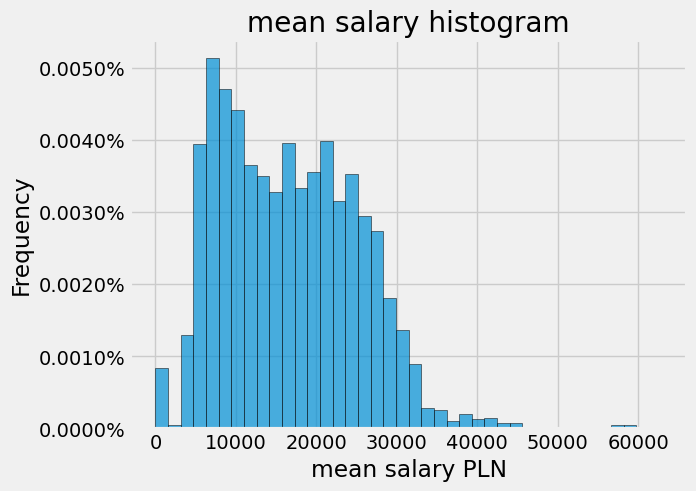

In [17]:
plt.hist(salaryMean_trainval,bins=40,density=True,edgecolor='black', alpha=0.7)
plt.xlabel('mean salary PLN')
plt.ylabel('Frequency')
plt.title('mean salary histogram')
formatter = mticker.PercentFormatter(xmax=1, decimals=4)
plt.gca().yaxis.set_major_formatter(formatter)

plt.show()



Salary no higher than 50000 - otherwise outler
Lots of salaries near zeroes, probably invalid specification of salary or lack there of


In [18]:
# TRANSFORMATION 1 - trim salary based on train/val histogram outlier data
factSkills_pivot_trainval, salaryMean_trainval = t1_trim_total_salary_range(
    factSkills_pivot_trainval,
    salaryMean_trainval,
    2000,
    50000
)

##### Salary analysis per job Seniority levels

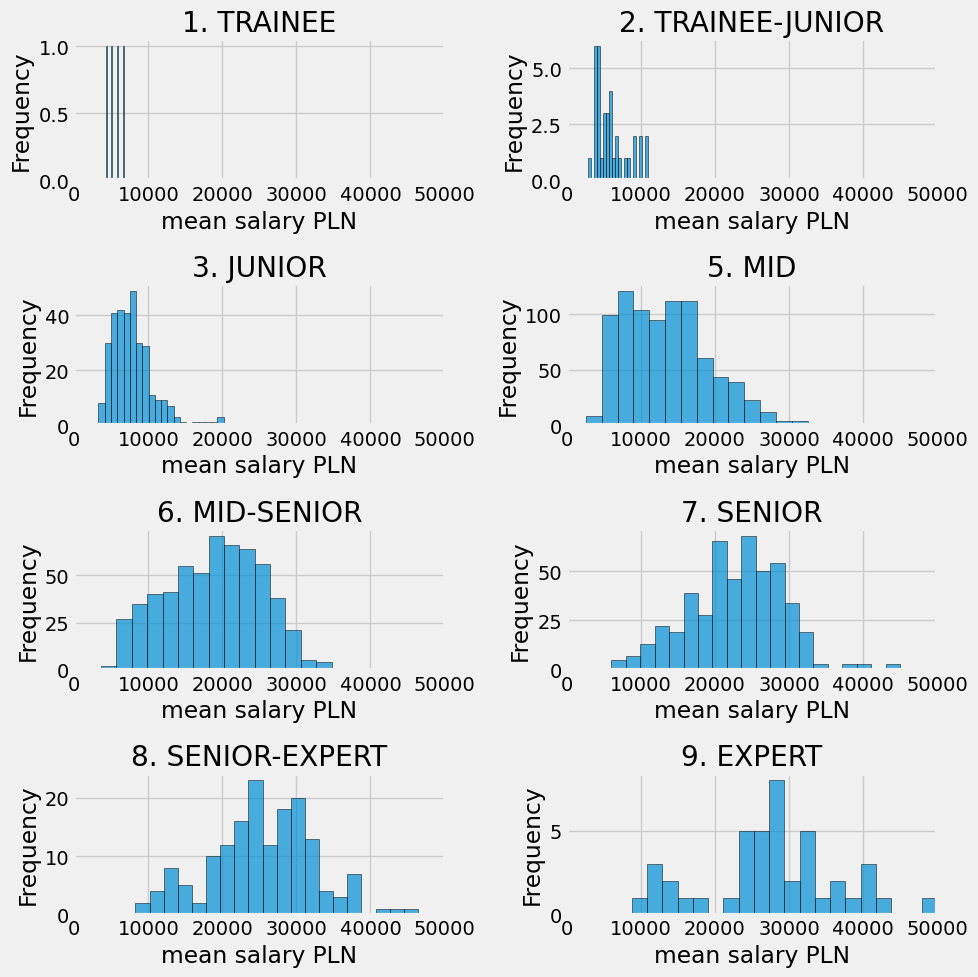

In [19]:
# Concat salary and df for a moment in temporary df
temp_df = pd.concat([factSkills_pivot_trainval['jobSeniorityNum'],salaryMean_trainval], axis=1)
temp_df.columns = ['jobSeniorityNum','salaryMean_trainval'] # Label columns

# Merge seniority levels with seniority number (for labelling)
temp_df = pd.merge(temp_df, seniority_levels_trainval_df, on='jobSeniorityNum', how='left')
groups = np.sort(temp_df['jobSeniorityNum'].unique()) # Unique seniority numbers

# Setup a figure grid
fig, axes = plt.subplots(nrows=4, ncols=2,
                         figsize=(10,10))
# Fetch maximum salary
max_salary = temp_df['salaryMean_trainval'].max()

# For every group (and resulting histogram)
for i, group in enumerate(groups):
    ax = axes.flatten()[i] # Set appropriate axis
    data = temp_df.query(' jobSeniorityNum == @group ')
    ax.hist(data['salaryMean_trainval'], bins=20, alpha=0.7, density=False,edgecolor='black')
    ax.set_xlabel('mean salary PLN')
    ax.set_ylabel('Frequency')
    ax.set_title(f'{data["seniority_level"].iloc[0]}')
    ax.set_xlim(0, max_salary)

plt.tight_layout()
plt.show()


There are some seniority levels (eg senior-expert) where there are two sub distributions (around 15K and 25K). That is however acceptable as probably category based.
Will try the 3 sigma outlier approach per category - if drop out is significant, perhaps category crossed with seniority instead

##### Trimming salary outliers within job categories

In [20]:
# Setup a new temp
temp_df = pd.concat([factSkills_pivot_trainval,salaryMean_trainval.rename('salaryMean_trainval')],axis=1)

# Group salary by job seniority
grouped_data = temp_df.groupby('jobSeniorityNum')['salaryMean_trainval']

# Calculate means and sds per group
mean_per_group = grouped_data.mean()
std_per_group = grouped_data.std()

# Set up lower and upper bounds
lower_bounds = mean_per_group - 3 * std_per_group
upper_bounds = mean_per_group + 3 * std_per_group

# build a df of outliers are -3, + 3 sd per consecutive seniority levels
lower_upper_bounds = pd.DataFrame({
    'lower_bounds': lower_bounds,
    'upper_bounds': upper_bounds
    })

# Save df as pickle for later testing application
lower_upper_bounds.to_pickle('lower_upper_bound.pkl')



In [21]:
# TRANSFORMATION 2 - trim salary based on 3sigma outlier per job seniority
# LOAD AND MERGE required to test set
factSkills_pivot_trainval, salaryMean_trainval = t2_trim_salary_per_seniority(factSkills_pivot_trainval,
                                                         salaryMean_trainval,
                                                         lower_upper_bounds)


17 rows removed


Only 17 rows removed, the database is pretty much stable

In [22]:
factSkills_pivot_trainval_skills = factSkills_pivot_trainval.drop(columns=jobCategories,axis=1)
factSkills_pivot_trainval_categories = factSkills_pivot_trainval[jobCategories]


In [23]:
# Making categories a one-column categorical variable for the same of analysis
categoriesAgr = single_column_categories(factSkills_pivot_trainval_categories)
categoriesAgr.to_pickle('categoriesAgr_trainval.pkl') # Save to pickle for later use

## 3. JOB CATEGORY SIMILARITY AGGREGATION 

Understanding if categories could be grouped by similarity in terms of salary, seniority levels and skill demands

#### Grouping, aggregation of job categories

In [24]:
# Dictionary for salary and job seniority (different measures - means)
agg_dict = {'salaryMean_trainval': 'mean',
            'jobSeniorityNum': 'mean'}

# For every column in the dataset
for column in factSkills_pivot_trainval_skills:
    # If the column not salary and not job seniority, perform frequency
    if column != 'jobSeniorityNum' and column != 'salaryMean_trainval':
        agg_dict[column] = lambda x: x.sum() / len(x)

# Temporary mini - df for salary and categories
temp_df = pd.DataFrame({
    'salaryMean_trainval': salaryMean_trainval, 
    'categoriesAgr': categoriesAgr})

# Join with the main df
temp_df = pd.concat([factSkills_pivot_trainval_skills,temp_df],axis=1)
# Perform grouping by agg_dict
temp_df = temp_df.groupby([categoriesAgr]).agg(agg_dict)
# Drop small skills to focus on key ones
temp_df = temp_df.drop(temp_df.columns[temp_df.max() < 0.1], axis=1)

# Standarize every row separately for row heatmap
standarize_row = lambda row: (row - row.mean()) / row.std()

# Transpose for visualization comfort
temp_df_transposed = temp_df.transpose()

# Apply standarize row lambda function
temp_df_transposed_standarize = temp_df_transposed.apply(standarize_row, axis=1)


#### Heatmap: mean salary, job seniority, skills per category

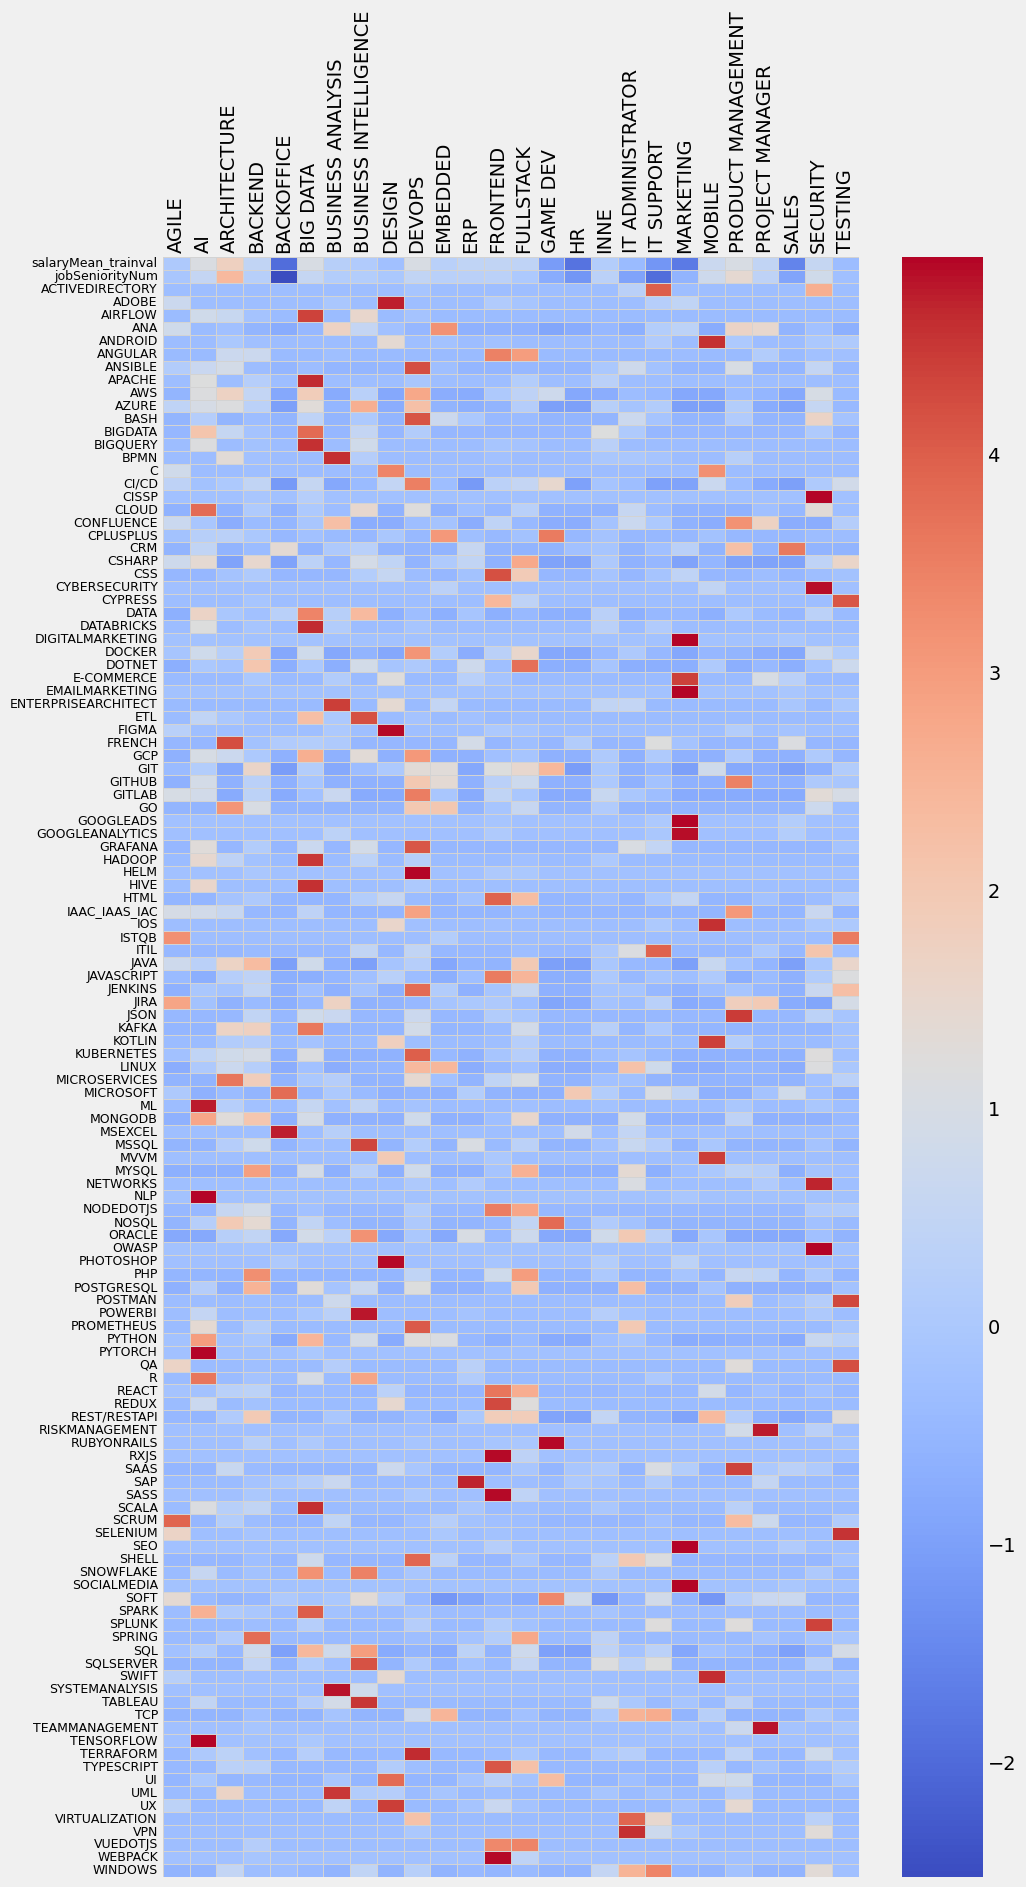

In [25]:
# Setup a heatmap
plt.figure(figsize=(10,20))
plt.yticks(fontsize=9)
heatmap = sns.heatmap(temp_df_transposed_standarize, cmap='coolwarm', linecolor='lightgrey',linewidth=0.5)
heatmap.xaxis.tick_top()
heatmap.set_xticklabels(heatmap.get_xticklabels(),rotation=90)
plt.show()
# There are many heat points, segmentation needed for similarities

There are clearly ome patterns, but not apparent at first sight. There is for example backend and frontent skill similarities

#### Hclust segmentation based on similarities

In [26]:
# Set up a standard scaler
scaler = StandardScaler()
# Scale the temporary grouped df
scaled_data = scaler.fit_transform(temp_df)

# Calculate ward similarity (maximises withinss, minimizes betweenss)
dist_matrix = linkage(scaled_data, method='ward')

# Threshold for coloring
threshold = 15

# Perform automatic segmentation
clusters = fcluster(dist_matrix, t=threshold, criterion='distance')


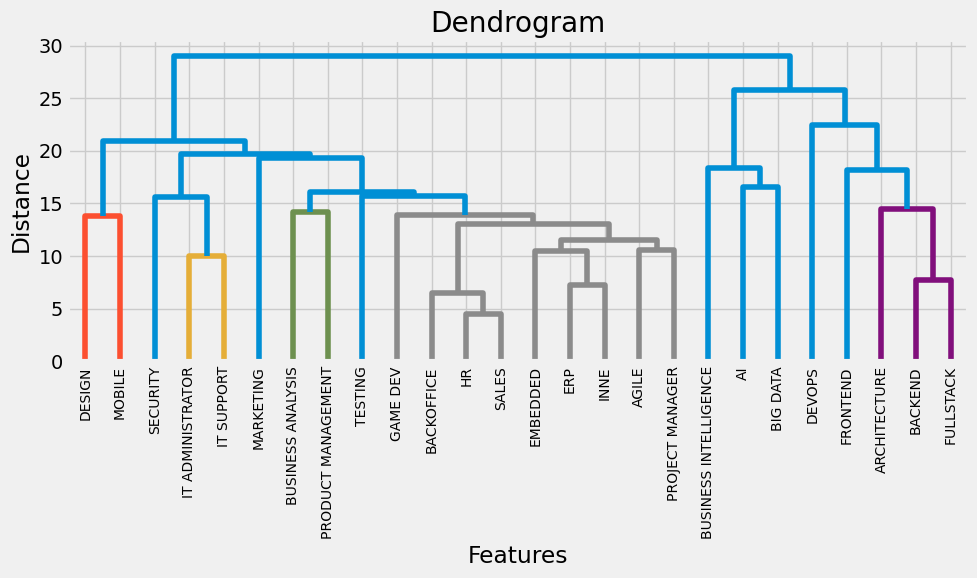

In [27]:
# Set up a dendrogram plot
plt.figure(figsize=(10,6))
# Build and fine-tune a cluster dendrogram
dendrogram = dendrogram(dist_matrix,labels=temp_df.index,
                                orientation='top',
                                color_threshold=threshold)

plt.xlabel('Features')
plt.ylabel('Distance')
plt.title('Dendrogram')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

The denodram manages to depict similarities between categories, but cutoff approach will be ineffective. Manual classification based on obtained groups needed

#### Final aggregation of job categories for modelling

In [28]:
# Manual aggregation based on the above clusters
factSkills_pivot_trainval = recode_categories_to_segments(factSkills_pivot_trainval,categoriesAgr)


In [29]:
# Save the result
factSkills_pivot_trainval.to_pickle('factSkills_pivot_trainval_cleaned.pkl')
salaryMean_trainval.to_pickle('salaryMean_trainval_cleaned.pkl')

## 4. EXPLORATORY DATA ANALYSIS

This section is an extension to Tableu dashboards that depict core popularity and skill characteristics. Thus EDA focuses on meta-classification of skills and Prinicipal Component Analysis for possible dimensionality reduction

#### Data load and trimming

In [30]:
# Load data and stick to X_train, X_val splits
factSkills_pivot_trainval = pd.read_pickle('factSkills_pivot_trainval_cleaned.pkl')
salaryMean_trainval = pd.read_pickle('salaryMean_trainval_cleaned.pkl')

# Keep focus on skills and seniority level from now on
factSkills_pivot_trainval = factSkills_pivot_trainval.loc[:, ~factSkills_pivot_trainval.columns.str.startswith('cat')]
factSkills_pivot_trainval = factSkills_pivot_trainval.drop(columns=jobCategories,axis=1)

# Split to train and val again to focus EDA on the train set
factSkills_pivot_train, factSkills_pivot_val, salaryMean_train, salaryMean_val = train_val_split(
    factSkills_pivot_trainval,salaryMean_trainval
)


In [31]:
# 1. Correlation between y and X
correlation = factSkills_pivot_train.corrwith(salaryMean_trainval)
correlation.sort_values(ascending=False)



AWS                 0.258299
KUBERNETES          0.246694
JAVA                0.231389
PYTHON              0.216981
DOCKER              0.202083
                      ...   
DIGITALMARKETING   -0.118003
GOOGLEANALYTICS    -0.130183
SOCIALMEDIA        -0.131510
GOOGLEADS          -0.134603
MICROSOFT          -0.286101
Length: 212, dtype: float64

Correlations are not high, but possibly sufficient to explain salary levels

In [32]:
# Perform EDA on limited skills, only those with significant frequenncies denoted by cutoff
factSkills_pivot_train_key_skills = drop_insignificant_columns(factSkills_pivot_train,0.05)

#### Correlation heatmap of most essential skills

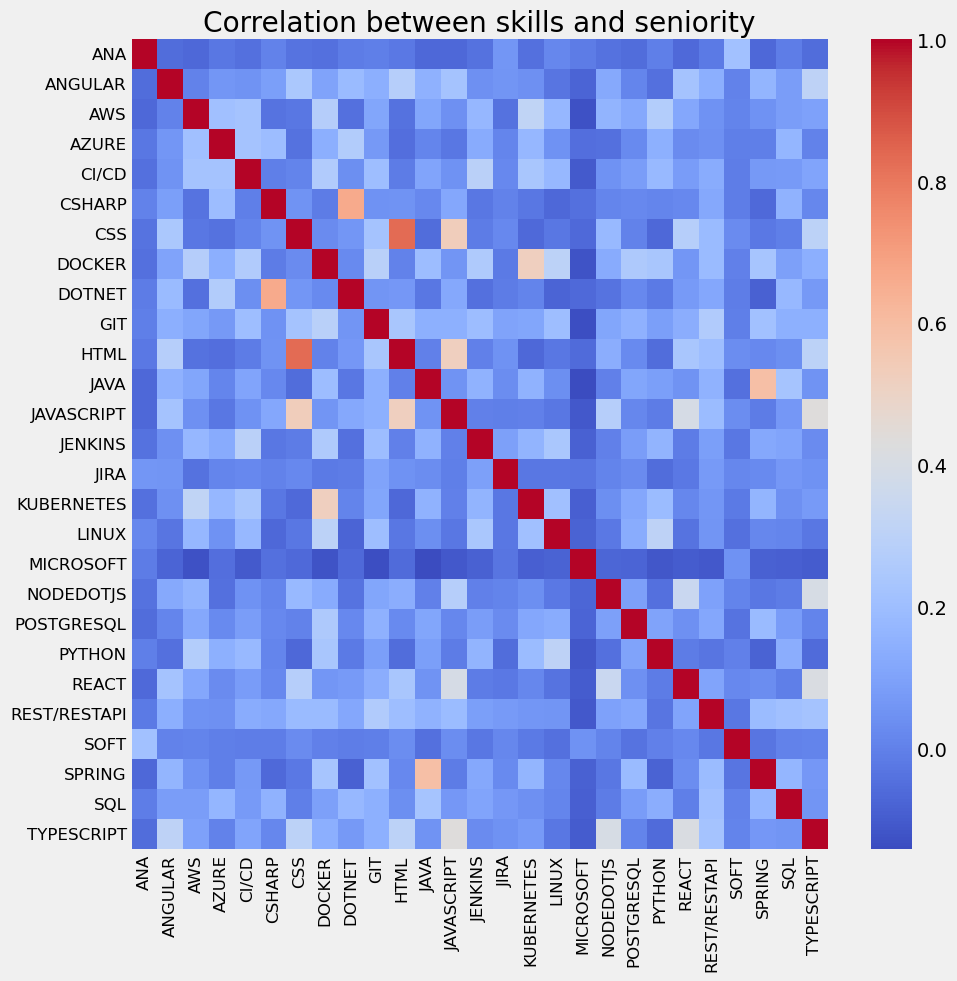

In [33]:
#corr_matrix = factSkills_pivot.corr()
corr_matrix = factSkills_pivot_train_key_skills.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.)
plt.title('Correlation between skills and seniority')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()



There are single stronger correlations, some are self-explainatory like HTML - CSS

#### Hiearchical clustering to understand co-demands

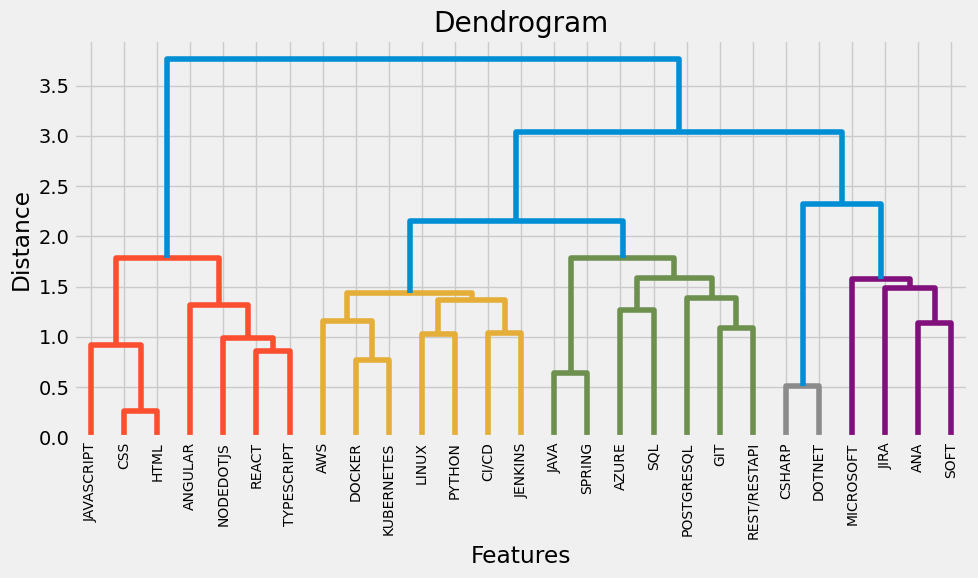

In [34]:
linkage = hierarchy.linkage(corr_matrix, method='ward') # Ward clustering correlation-based
threshold = 2  # Distance that depicts cluster segments
plt.figure(figsize=(10,6))
# Build and fine-tune a cluster dendrogram
dendrogram = hierarchy.dendrogram(linkage,labels=corr_matrix.columns,
                                orientation='top',
                                color_threshold=threshold)

plt.xlabel('Features')
plt.ylabel('Distance')
plt.title('Dendrogram')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Much cleaner segmentation, with 5 clusters and clear cutoff

#### Skill co-requirement (MDS scaling)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


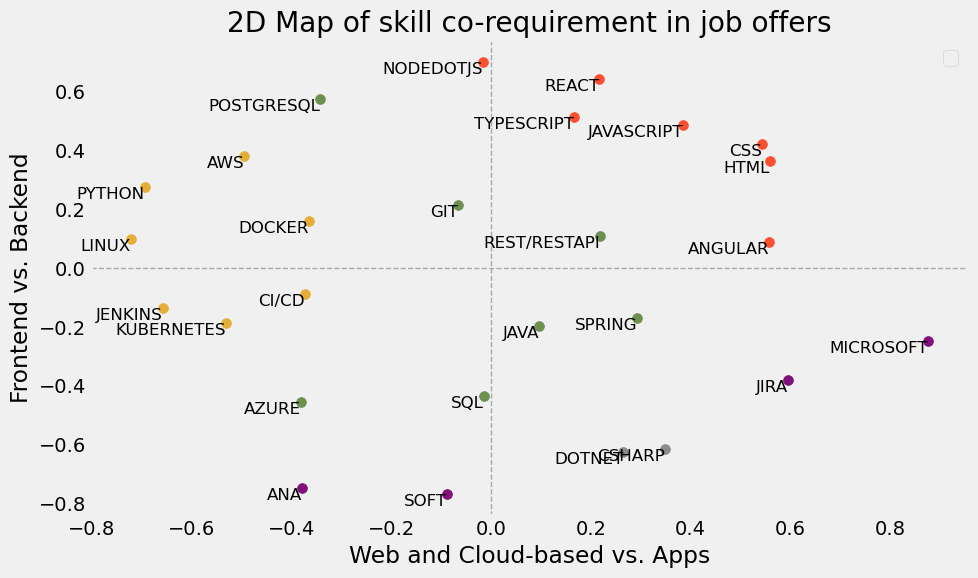

In [35]:
# Cluster data based on threshold
clusters = hierarchy.fcluster(linkage,threshold, criterion='distance')
feature_colors = {feature: f'C{cluster}' for feature, cluster in zip(corr_matrix.columns, clusters)}

# Dissimilarity matrix from correlation
daisy = 1 - corr_matrix.values

# Perform MDS to corr matrix
mds = MDS(n_components=2, random_state=234,dissimilarity='precomputed',normalized_stress='auto')
mds_coords = mds.fit_transform(daisy)


# Plot the result
plt.figure(figsize=(10,6))
for i, (x,y) in enumerate(mds_coords):
    plt.scatter(x,y, color=feature_colors[corr_matrix.columns[i]],s=50)
    plt.text(x, y, corr_matrix.columns[i], fontsize=12, ha='right', va='top')

plt.axhline(0, color='darkgrey', linestyle='--', linewidth=1)
plt.axvline(0, color='darkgrey', linestyle='--', linewidth=1)
    
plt.xlabel('Web and Cloud-based vs. Apps')
plt.ylabel('Frontend vs. Backend')
plt.title('2D Map of skill co-requirement in job offers')
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

There are two meta dimensions of key skills:
- web and cloud based applications (eg. AZURE, KUBERNETES, PYTHON) vs.APPS / DEVELOPMENT (eg. MICROSOFT, CSS, JIRA)
- Frontend (REACH, CSS, POSTGRES) vs. BACKEND (SQL, AZURE, JAVA, C#)

### Dimensionality reduction - PCA

To understand if over 200 hundred skills could be simiplied to a number of pricipal components and therefore improve classification later

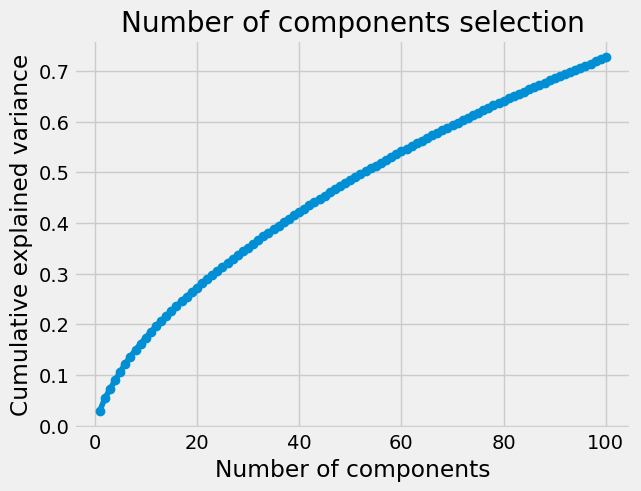

In [36]:
scaler = StandardScaler() # Perofrm scaling to standarize data
X_train_scaled = scaler.fit_transform(factSkills_pivot_train)

# set up a PCA
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)

# How much variance is explained per PCA
explained_variance_ratio = pca.explained_variance_ratio_
 
# Cumulative variance explained
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Loadings - how are factors built
loadings = pca.components_

# Eigenvalues to Kaiser criteriow of eigenvalue > 1 to be significant
eigenvalues = pca.explained_variance_

# Make a chart
max_range = 100
plt.plot(range(1, max_range+1),cumulative_explained_variance[:max_range], marker='o')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('Number of components selection')
plt.grid(True)
plt.show()
# 20 components is where momentum stops, but still only about 0,3 variance captured

Many components (>60) needed to explain the dataset.
Let's see what the Kaiser Rule says (fact that factor should explain at least an equivalent of an input variable)

In [37]:
# Optimize number of PCa by Kaiser rule
n_components = np.sum(eigenvalues>=1)
# n_components = 20 # Forsted by user
X_pca_optimal = X_train_pca[:, :n_components]

# Optain PCA DF's: full and trimmed to 20
components_df_train_full = pd.DataFrame(data=X_pca_optimal, columns=['PC{}'.format(i+1) for i in range(n_components)])
components_df_train_20 = components_df_train_full.iloc[:,:20]
loadings_df_train = pd.DataFrame(data=loadings[:, :n_components], columns=['PC{}'.format(i+1) for i in range(n_components)], index=factSkills_pivot_trainval.columns)




Over 80 components, virtually impossible to explain. Alternative, 20 component solution also extracted

##### Applying PCA to validation dataset

In [38]:
X_val_scaled = scaler.transform(factSkills_pivot_val)
X_val_pca = pca.transform(X_val_scaled)
X_val_pca_optimal = X_val_pca[:, :n_components]

components_df_val_full = pd.DataFrame(data=X_val_pca_optimal, columns=['PC{}'.format(i+1) for i in range(n_components)])
components_df_val_20 = components_df_val_full.iloc[:,:20]


End of EDA. Let's move to variable selection


## 5. VARIABLE SELECTION

Having over 200 explainatory variables and a relatively small dataset may be inefficient in terms of performing a regression task. Therefore most necessary skill selection is needed to simplify the process and accept the fact that not every skill is going to be covered in the analysis.

#### Dataset preparation for variable selection

,mse_lr,mse_gbr,vars,newVars,delta_mse_lr,delta_mse_gbr
0,3.749745e+07,3.708539e+07,[jobSeniorityNum],NaN,NaN,NaN
1,3.502299e+07,3.434910e+07,"[MICROSOFT, jobSeniorityNum]",MICROSOFT,-2.474464e+06,-2.736284e+06
2,3.371251e+07,3.318390e+07,"[AWS, MICROSOFT, jobSeniorityNum]",[AWS],-1.310481e+06,-1.165200e+06
3,3.283227e+07,3.224191e+07,"[AWS, KUBERNETES, MICROSOFT, jobSeniorityNum]",[KUBERNETES],-8.802382e+05,-9.419923e+05
4,3.199757e+07,3.154470e+07,"[AWS, JAVA, KUBERNETES, MICROSOFT, jobSeniorit...",[JAVA],-8.347009e+05,-6.972086e+05


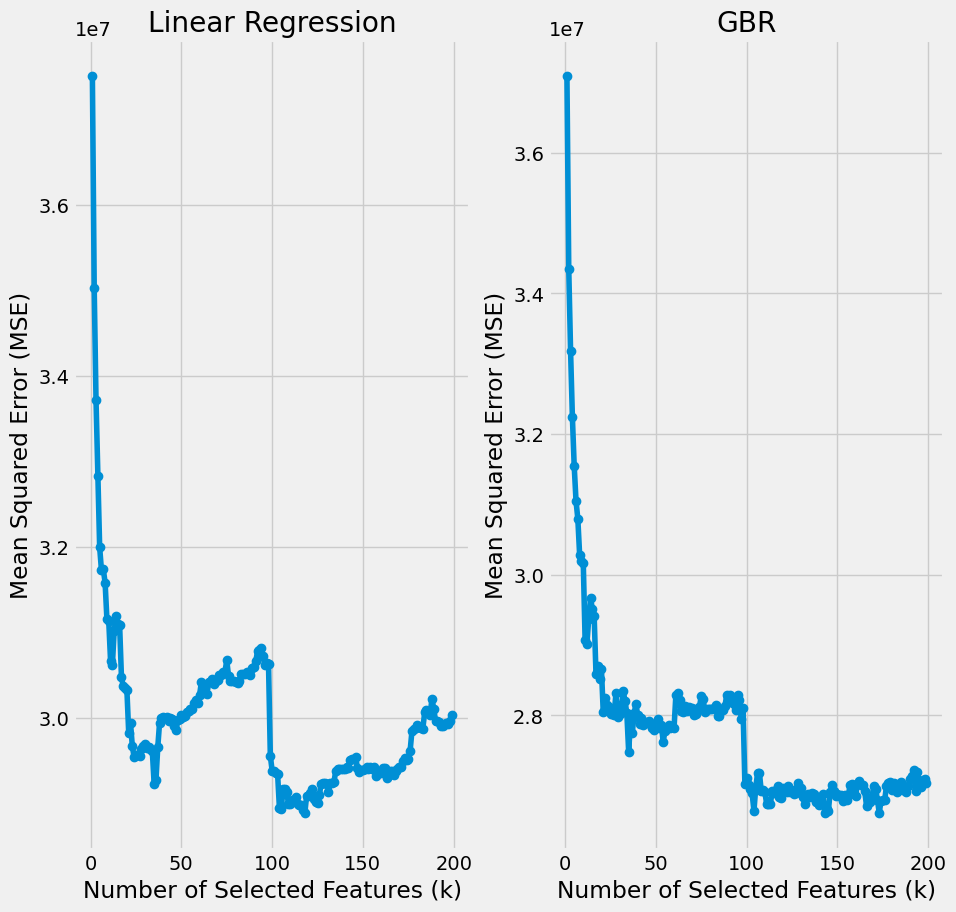

In [39]:
# Find, how many skills are enough to predict salary
k_values = range(1,200)
k_list = [] # Empty listy for k
mse1_list = [] # Empty list for mean sq err
mse2_list = []
selected_vars_list = []
scaler = StandardScaler()
for k in k_values:
    selector = SelectKBest(score_func=f_regression, k=k) # Stat test based model, testing for var significance against y
    # Train on selected k vars
    factSkills_train_selected = selector.fit_transform(factSkills_pivot_train,  
                                                       salaryMean_train)
    
    # Validate
    factSkills_val_selected = selector.transform(factSkills_pivot_val)
    
    # Scale data
    factSkills_train_selected = scaler.fit_transform(factSkills_train_selected)
    factSkills_val_selected = scaler.transform(factSkills_val_selected)

    # Target model
    model1 = LinearRegression()
    model2 = GradientBoostingRegressor()
    # Fit to training data
    model1.fit(factSkills_train_selected,salaryMean_train)
    model2.fit(factSkills_train_selected,salaryMean_train)
    
    # Predict on validation set
    salaryMean_val_pred1 = model1.predict(factSkills_val_selected)
    salaryMean_val_pred2 = model2.predict(factSkills_val_selected)
    
    # MSE as validation
    mse1 = mean_squared_error(salaryMean_val, salaryMean_val_pred1)
    mse2 = mean_squared_error(salaryMean_val, salaryMean_val_pred2)

    # Append results
    k_list.append(k)
    mse1_list.append(mse1)
    mse2_list.append(mse2)

    selected_indices = selector.get_support(indices=True)
    # Retrieve the original feature names based on the selected indices
    selected_vars_list.append(factSkills_pivot_train.columns[selected_indices].values)

temp_df = pd.DataFrame({
    'mse_lr': mse1_list,
    'mse_gbr': mse2_list,
    'vars': list(selected_vars_list)
                        })

temp_df['newVars'] = np.nan
temp_df['delta_mse_lr'] = np.nan
temp_df['delta_mse_gbr'] = np.nan

for i in range(1, len(temp_df)):
    vars_current = temp_df.loc[i, 'vars']
    vars_previous = temp_df.loc[i-1,'vars']

    temp_df.loc[i, 'newVars'] = list(set(vars_current) - set(vars_previous))

    temp_df.loc[i, 'delta_mse_lr'] = temp_df.loc[i, 'mse_lr'] - temp_df.loc[i-1, 'mse_lr']
    temp_df.loc[i, 'delta_mse_gbr'] = temp_df.loc[i, 'mse_gbr'] - temp_df.loc[i-1, 'mse_gbr']



# Plot results
fig, axs = plt.subplots(1, 2, figsize=(10, 10))

axs[0].plot(k_list, mse1_list, marker='o')
axs[0].set_xlabel('Number of Selected Features (k)')
axs[0].set_ylabel('Mean Squared Error (MSE)')
axs[0].set_title('Linear Regression')
axs[0].grid(True)

# Plot for the second subplot
axs[1].plot(k_list, mse2_list, marker='o')
axs[1].set_xlabel('Number of Selected Features (k)')
axs[1].set_ylabel('Mean Squared Error (MSE)')
axs[1].set_title('GBR')
axs[1].grid(True)




temp_df.head()


In [ ]:
pd.options.display.float_format = '{:.4f}'.format
temp_df.head(110).tail(20)

,mse_lr,mse_gbr,vars,newVars,delta_mse_lr,delta_mse_gbr
90,30665779.2149,28252724.6690,"[AIRFLOW, AKKA, ANGULAR, ANSIBLE, APACHE, AWS,...",[WEBPACK],70712.3732,45733.8092
91,30784672.4224,28226758.4394,"[AIRFLOW, AKKA, ANGULAR, ANSIBLE, APACHE, AWS,...",[PROMETHEUS],118893.2075,-25966.2296
92,30794825.4771,28256542.1868,"[AIRFLOW, AKKA, ANGULAR, ANSIBLE, APACHE, AWS,...",[KIBANA],10153.0547,29783.7474
93,30815489.2513,28158962.6998,"[AIRFLOW, AKKA, ANGULAR, ANSIBLE, APACHE, AWS,...",[JAVASCRIPT],20663.7741,-97579.4871
94,30721345.9061,28264033.9931,"[AIRFLOW, AKKA, ANGULAR, ANSIBLE, APACHE, AWS,...",[SNOWFLAKE],-94143.3452,105071.2933
95,30616054.0596,28208996.2306,"[AIRFLOW, AKKA, ANGULAR, ANSIBLE, APACHE, AWS,...",[POWERSHELL],-105291.8465,-55037.7625
96,30646672.6295,27879154.2451,"[AIRFLOW, AKKA, ANGULAR, ANSIBLE, APACHE, AWS,...",[TDD],30618.5699,-329841.9854
97,30633516.1609,28148261.1898,"[AIRFLOW, AKKA, ANGULAR, ANSIBLE, APACHE, AWS,...",[BITBUCKET],-13156.4686,269106.9447
98,29558498.4004,27020279.3542,"[AIRFLOW, AKKA, ANGULAR, ANSIBLE, APACHE, AWS,...",[SAP],-1075017.7605,-1127981.8356
99,29386066.7795,27052825.8355,"[AIRFLOW, AKKA, ANGULAR, ANSIBLE, APACHE, AWS,...",[SWIFT],-172431.6209,32546.4814


Pretty unstable result, though solidifies relatively around k=100.<br>
SAP is the skill that is not that frequent (significat), but makes an impact on 1-2 categories.


#### Final number of skills

In [ ]:
# ASSUME TOP  FEATURES AS MOST IMPORTANT
k = 105
selector = SelectKBest(score_func=f_regression, k=k)
factSkills_train_selected = selector.fit_transform(factSkills_pivot_train, salaryMean_train)
factSkills_val_selected = selector.transform(factSkills_pivot_val)

selected_indices = selector.get_support(indices=True)
# Retrieve the original feature names based on the selected indices
selected_features = factSkills_pivot_train.columns[selected_indices]
omitted_features = factSkills_pivot_train.drop(columns=selected_features)

# Save selected features to pickle for later usage
with open('selected_features.pkl', 'wb') as file:
    pickle.dump(selected_features, file)

pd.set_option('display.max_rows', 100)  # Set max rows to display as None (show all rows)

# Identify selected and omitted features
factSkills_pivot_train[selected_features].sum().sort_values(ascending=False)

# Omitted features with value counts
factSkills_pivot_train[omitted_features.columns].sum().sort_values(ascending=False).head(50)


ANA               207.0000
JIRA              176.0000
HTML              170.0000
CSS               165.0000
POSTGRESQL        112.0000
MYSQL              97.0000
PHP                90.0000
WINDOWS            87.0000
CONFLUENCE         74.0000
MSSQL              53.0000
SQLSERVER          51.0000
KNOW               49.0000
MAVEN              46.0000
SELENIUM           45.0000
ANDROID            44.0000
REDUX              42.0000
UI                 42.0000
RABBITMQ           41.0000
OOP                40.0000
JUNIT              39.0000
SYMFONY            38.0000
IOS                36.0000
UML                32.0000
ENTITYFRAMEWORK    31.0000
BPMN               29.0000
SCRUM              28.0000
TCP                28.0000
SAAS               28.0000
UX                 28.0000
TEAMPLAYER         27.0000
HTTP               27.0000
POSTMAN            27.0000
SASS               25.0000
POWERBI            25.0000
ITIL               25.0000
SHELL              24.0000
VISUALSTUDIO       24.0000
X

Some popular skills are excluded from the variable selection, therefore manually forced in to final solution (to account to reach building strategies)

In [ ]:
# Force some of the most popular skills into the list
allvars = list(selected_features) + ['JIRA', 'HTML', 'CSS','POSTGRESQL', 'MYSQL','PHP','CONFLUENCE',
                                     'ANA']

# Ensure list is unique
allvars = list(set(allvars))

# Sort alphabetically
allvars.sort()


In [ ]:
# Stick to selected skills for the later part of the analysis
factSkills_pivot_train_selected = factSkills_pivot_train[allvars]
factSkills_pivot_val_selected = factSkills_pivot_val[allvars]
# Save vars to a file for re-use in testing
with open('selected_features.pkl','wb') as file:
    pickle.dump(allvars,file)

With skills selected, we are ready to move to modelling stage

## 6. MODELLING

### Model selection

#### Data standarization

In [ ]:
factSkills_pivot_train_selected = factSkills_pivot_train_selected.sort_index(axis=1)
scaler = StandardScaler() # Initialize scaler for 0 mean and 1 sd
X_train_scaled = scaler.fit_transform(factSkills_pivot_train_selected) # Learn scaler on train set
joblib.dump(scaler,'standard_scaler.pkl') # Save standard scaler for later use

X_val_scaled = scaler.transform(factSkills_pivot_val_selected) # Appply learned scaler to val data
y_train, y_val = salaryMean_train, salaryMean_val, # Reference variables by different name

#### Model screening

Need to screen models on general perspective to understand what could work

In [ ]:
# Get all the regression models, without hyperparameters optimization
all_models = []
all_models.append(('lr',LinearRegression()))
all_models.append(('lasso',Lasso()))
all_models.append(('en',ElasticNet()))
all_models.append(('knn',KNeighborsRegressor()))
all_models.append(('dtr',DecisionTreeRegressor()))
all_models.append(('svr',SVR()))
all_models.append(('rfr',RandomForestRegressor()))
all_models.append(('gbr',GradientBoostingRegressor()))

# Get all the X data 
all_X_train = []
all_X_train.append(X_train_scaled)
all_X_train.append(components_df_train_full)
all_X_train.append(components_df_train_20)


In [ ]:
# Set up evluation arrays
results = []
names = []
datasets = []

for key, dataset in enumerate(all_X_train):
    for name, model in all_models:
        scores = cross_val_score(model, dataset, y_train, 
                                cv=5,  
                                scoring='r2') # Effectovely MSE
        #rmse = (-scores) ** (1/2) # Root Mean Squared Error from negative MSE
        results.append(scores.mean())
        names.append(name)
        datasets.append(key)

all_model_results = pd.DataFrame({"dataset": datasets, "model":names, "results": results})
all_model_results


,dataset,model,results
0,0,lr,0.5914
1,0,lasso,0.5917
2,0,en,0.5660
3,0,knn,0.4114
4,0,dtr,0.4441
5,0,svr,-0.0028
6,0,rfr,0.6177
7,0,gbr,0.6097
8,1,lr,0.4509
9,1,lasso,0.4510


Variable selection yields much better results than PCA, especially if narrowed down to 20 vars<br>
Models that make the screening:<br>
Linear Regression - simplest, quickest, r2 is good enough<br>
Lasso - further variable screening, though unlikely for Recommender usability<br>
Elastic Net - both Rdge (L2 regularization - small non-zero coef for stability) and <br>
Lasso (L1 - sparse vars selection regularization) combined<br>
Random Forest - defeintely worth considering and optimizing<br>
Gradient Boosting Regressor - probabily most fitting to the problem given its interactive nature

### Linear Regression, Lasso, Elastic Net

In [ ]:
# Parameters for elastic net
param_grid_elastic_net = {
    'alpha': [0.1, 0.5, 1.0], # How strong to regulate the model
    'l1_ratio': [0.2, 0.5, 0.8] # Elastic Net mixing L1/L2 parameter
}

# Parameters for Lasso
param_grid_lasso = {
    'alpha': [0.1, 0.5, 1.0] # How strong to regulate the model
}

# Set up the models
lr = LinearRegression()
lasso = Lasso()
elastic_net = ElasticNet()

# Grid search for lasso and elastic net
grid_search_lasso = GridSearchCV(estimator=lasso, 
                                param_grid=param_grid_lasso,
                                cv=5,
                                scoring='r2')
grid_search_elastic_net = GridSearchCV(estimator=elastic_net, 
                                param_grid=param_grid_elastic_net, 
                                cv=5, 
                                scoring='r2')

# Fit to train data
lr.fit(X_train_scaled,y_train)
grid_search_lasso.fit(X_train_scaled, y_train)
grid_search_elastic_net.fit(X_train_scaled, y_train)


# Evaluate best configurations
best_params_lasso = grid_search_lasso.best_params_
best_score_lasso = grid_search_lasso.best_score_
best_model_lasso = grid_search_lasso.best_estimator_

best_params_elastic_net = grid_search_elastic_net.best_params_
best_score_elastic_net = grid_search_elastic_net.best_score_
best_model_elastic_net = grid_search_elastic_net.best_estimator_

lr_r2_score = lr.score(X_train_scaled, y_train)
# summarize the model
model_summary = pd.DataFrame({
    'model': ['lr', 'Lasso', 'elastic net'],
    'best_params': [np.nan, best_params_lasso, best_params_elastic_net],
    'r2': [lr_r2_score, best_score_lasso, best_score_elastic_net]
    })
model_summary


,model,best_params,r2
0,lr,NaN,0.6442
1,Lasso,{'alpha': 1.0},0.5917
2,elastic net,"{'alpha': 0.5, 'l1_ratio': 0.8}",0.5959


Lr performs better, clearly many vars are needed


In [ ]:
# Review of coef summary
lr_coeffs = dict(zip(factSkills_pivot_train[selected_features].columns, lr.coef_))
lasso_coeffs = dict(zip(factSkills_pivot_train[selected_features].columns, best_model_lasso.coef_))
elastic_net_coeffs = dict(zip(factSkills_pivot_train[selected_features].columns, best_model_elastic_net.coef_))

coef_df = pd.DataFrame({'LR': lr_coeffs,
                        'Lasso': lasso_coeffs,
                        "ElasticNet": elastic_net_coeffs})
coef_df.sort_values(by='LR', ascending=False)

coef_df.corr() 

,LR,Lasso,ElasticNet
LR,1.0000,1.0000,0.9851
Lasso,1.0000,1.0000,0.9859
ElasticNet,0.9851,0.9859,1.0000


All models yield very similar results, but lr tends to have higher terms especially within the top

#### Random forest - Set up a Grid search

##### Stage one - n-estimators and max-depth

{'bootstrap': True, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100} 0.5988106300257842


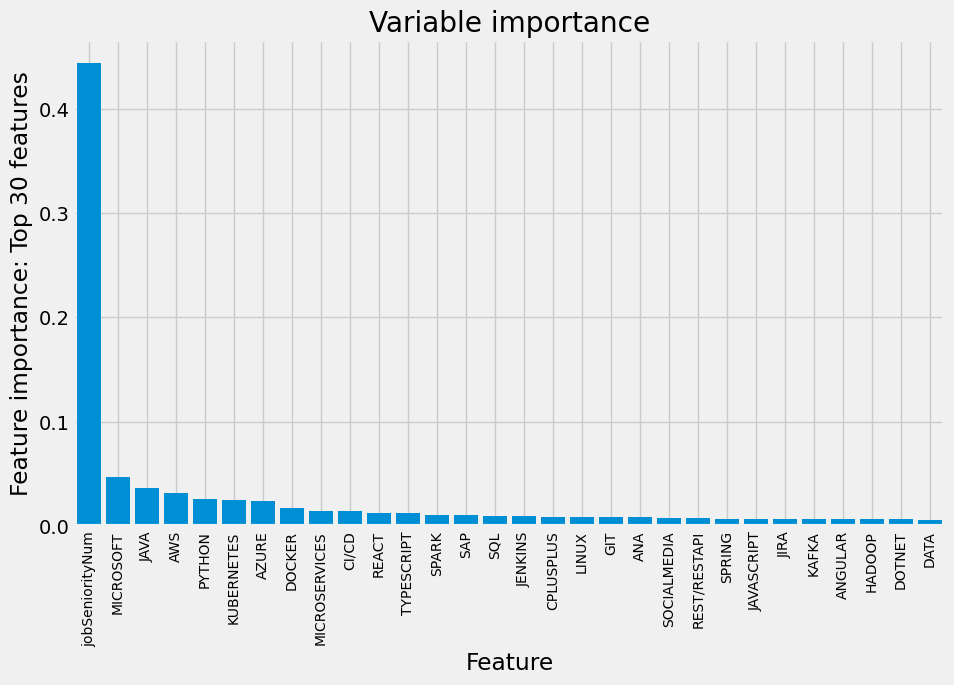

In [ ]:
param_grid = {
    'n_estimators': [10, 50, 100, 200, 300, 400, 800, 1000], # Number of trees in the forest
    'max_features': ['sqrt'], # Max number of features considered for splitting a node
    'max_depth': [10,20,30,40,50,60,80,100,None], # Max number of levels in each decision tree
    'min_samples_split': [5], # Min number of data points placed in a node before node is split
    'min_samples_leaf': [2], # Min number of data points allowed in a leaf node
    'bootstrap': [True] # Method of bootstrapping (With or without replacement)
}
grid_search = tree_tuning('rf',
                          factSkills_pivot_train_selected,
                          X_train_scaled,
                          y_train,
                          param_grid=param_grid,
                          verbose=0)

##### Max features and bootstrap optimization

{'bootstrap': False, 'max_depth': 50, 'max_features': 26, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100} 0.6443872034353463


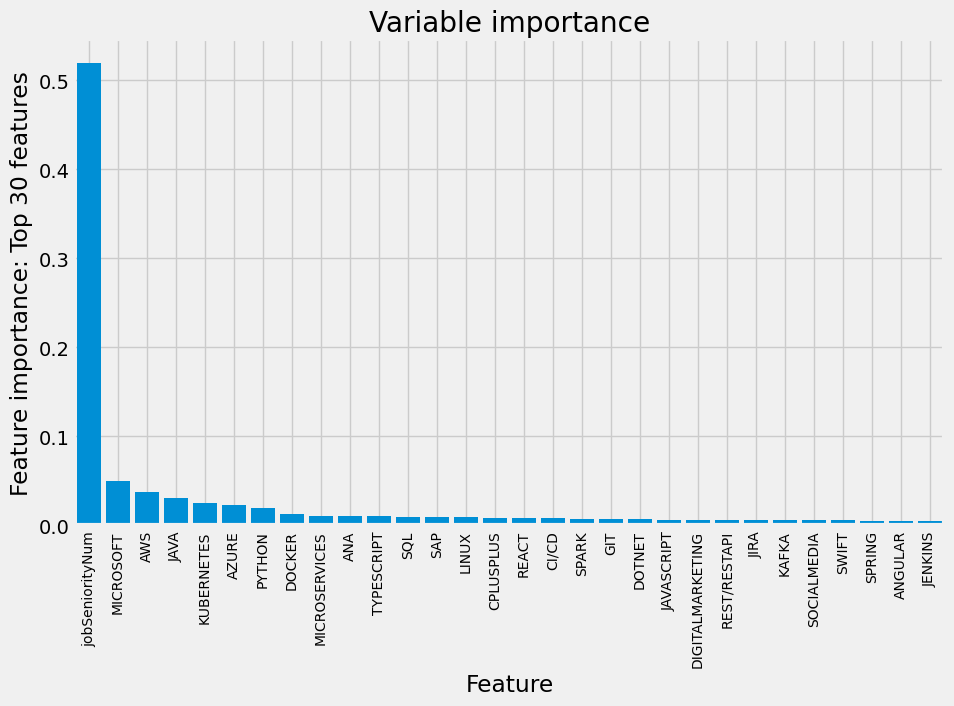

In [ ]:
param_grid = {
    'n_estimators': [80,100,120], # Number of trees in the forest
    'max_features': [8,'sqrt', 14, 18, 22, 26, 30], # Max number of features considered for splitting a node
    'max_depth': [50], # Max number of levels in each decision tree
    'min_samples_split': [5], # Min number of data points placed in a node before node is split
    'min_samples_leaf': [2], # Min number of data points allowed in a leaf node
    'bootstrap': [True, False] # Method of bootstrapping (With or without replacement)
}
grid_search = tree_tuning('rf',
                          factSkills_pivot_train_selected,
                          X_train_scaled,
                          y_train,
                          param_grid=param_grid,
                          verbose=0)

##### Min samples split and min samples leaf optimization

{'bootstrap': False, 'max_depth': 50, 'max_features': 26, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100} 0.6443872034353463


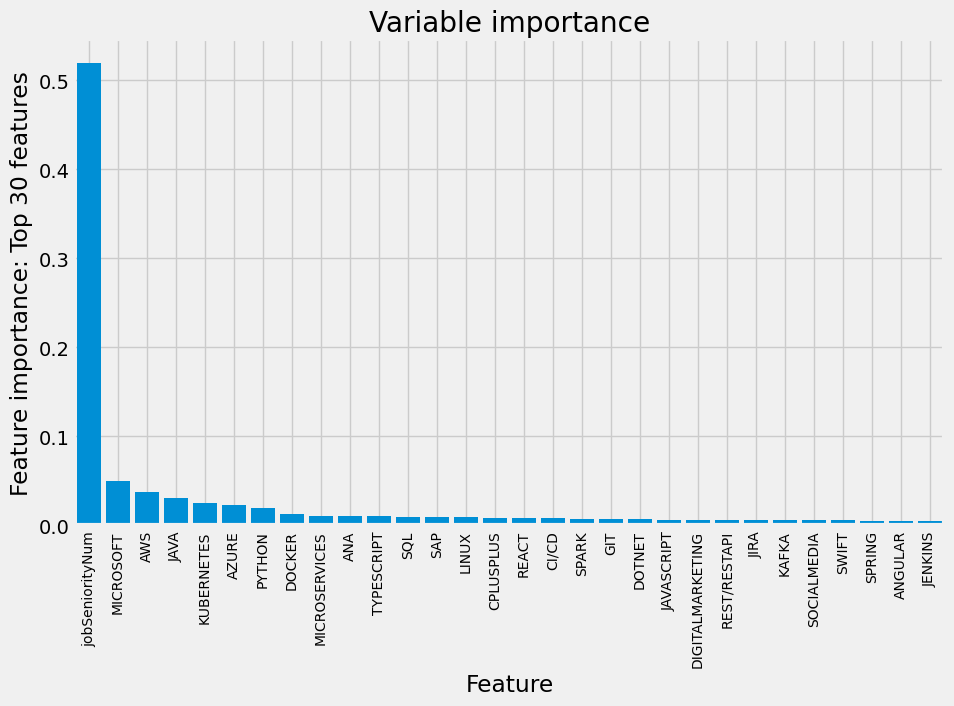

In [ ]:
param_grid = {
    'n_estimators': [100], # Number of trees in the forest
    'max_features': [26], # Max number of features considered for splitting a node
    'max_depth': [50], # Max number of levels in each decision tree
    'min_samples_split': [2,5,10,15], # Min number of data points placed in a node before node is split
    'min_samples_leaf': [1,2,4,8], # Min number of data points allowed in a leaf node
    'bootstrap': [False] # Method of bootstrapping (With or without replacement)
}
grid_search = tree_tuning('rf',
                          factSkills_pivot_train_selected,
                          X_train_scaled,
                          y_train,
                          param_grid=param_grid,
                          verbose=0)

##### Final random forest


In [ ]:
rfr = RandomForestRegressor(
    bootstrap=False,
    max_depth=50,
    max_features=26,
    min_samples_leaf=2,
    min_samples_split=5,
    n_estimators=100
)
rfr.fit(X_train_scaled,y_train)

RandomForestRegressor(bootstrap=False, max_depth=50, max_features=26,
                      min_samples_leaf=2, min_samples_split=5)

Finam model is relatively simple. Only 100 trees, but multiple features in every tree what makes sense in terms of broad skill set

#### Gradient Boosting Regressor - Set up a grid search

##### Stage 1 - n-estimators and learning rate

{'learning_rate': 0.05, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 50, 'min_samples_split': 10, 'n_estimators': 1200} 0.6004936815377118


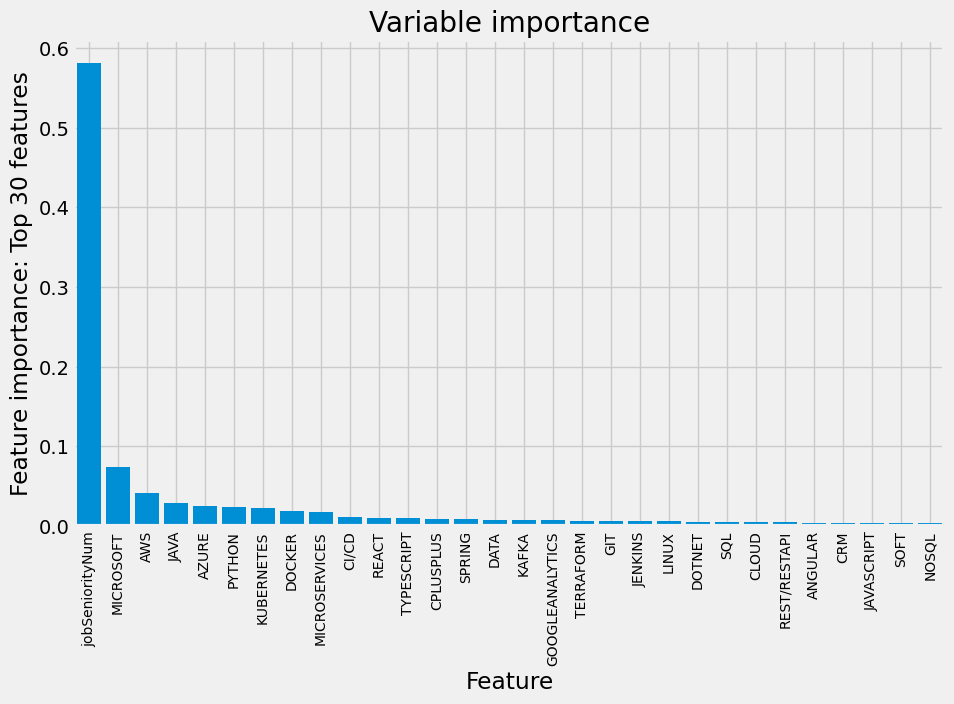

In [ ]:
param_grid = {
    'n_estimators': [10, 50, 100, 200, 400, 800, 1200], # number of boosting stages (higher - more complex)
    'max_depth': [5], # maximum depth of a single tree. The more = the more interactions, but overfit risk
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.4], # how quickly trees contribute to ensemble. Higher values are faster to learn, but risk overfitting
    'min_samples_split': [10], # 0,5% of train dataset size: min samples needed to split an internal node
    'min_samples_leaf': [50], # Number required to be a leaf node 
    'max_features': ['sqrt'] # number of features considered during each split
}
grid_search = tree_tuning('gbr',
                          factSkills_pivot_train_selected,
                          X_train_scaled,
                          y_train,
                          param_grid=param_grid,
                          verbose=0)

##### Stage 2 - max_depth, and num_samples split

{'learning_rate': 0.05, 'max_depth': 13, 'max_features': 'sqrt', 'min_samples_leaf': 50, 'min_samples_split': 2, 'n_estimators': 1200} 0.6065010541349745


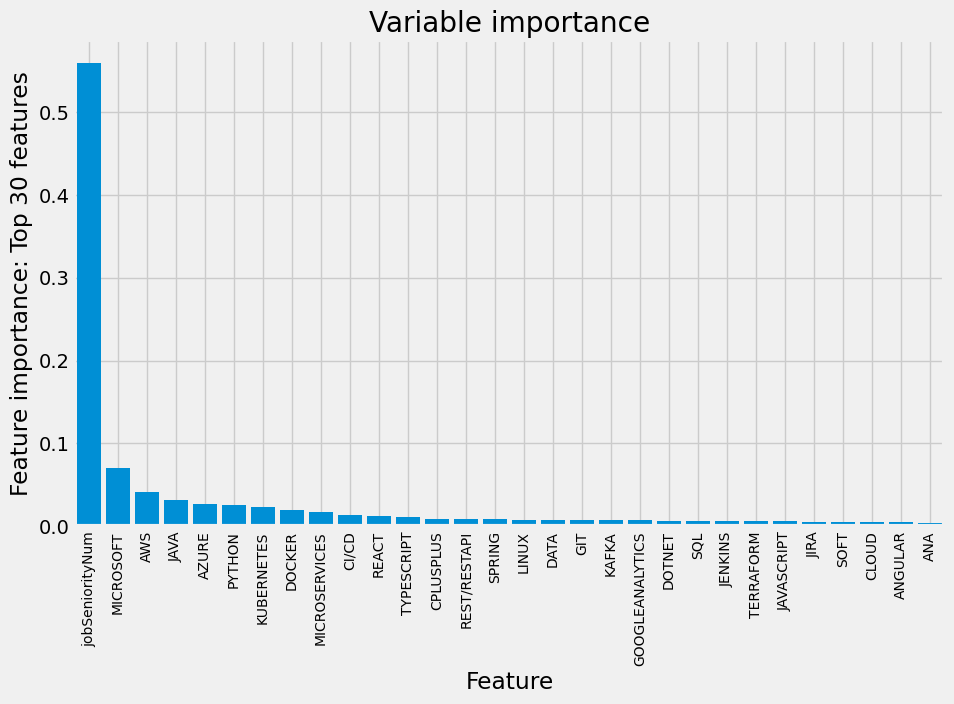

In [ ]:
param_grid = {
    'n_estimators': [1200], # number of boosting stages (higher - more complex)
    'max_depth': [5,9,13,17], # maximum depth of a single tree. The more = the more interactions, but overfit risk
    'learning_rate': [0.05], # how quickly trees contribute to ensemble. Higher values are faster to learn, but risk overfitting
    'min_samples_split': [2,5, 10, 20], # 0,5% of train dataset size: min samples needed to split an internal node
    'min_samples_leaf': [50], # Number required to be a leaf node 
    'max_features': ['sqrt'] # number of features considered during each split
}
grid_search = tree_tuning('gbr',
                          factSkills_pivot_train_selected,
                          X_train_scaled,
                          y_train,
                          param_grid=param_grid,
                          verbose=0)
# No significant improvement over stage 1 in score

#### Stage 3 - max features per tree

{'learning_rate': 0.05, 'max_depth': 13, 'max_features': 14, 'min_samples_leaf': 50, 'min_samples_split': 2, 'n_estimators': 1200} 0.6066167504939685


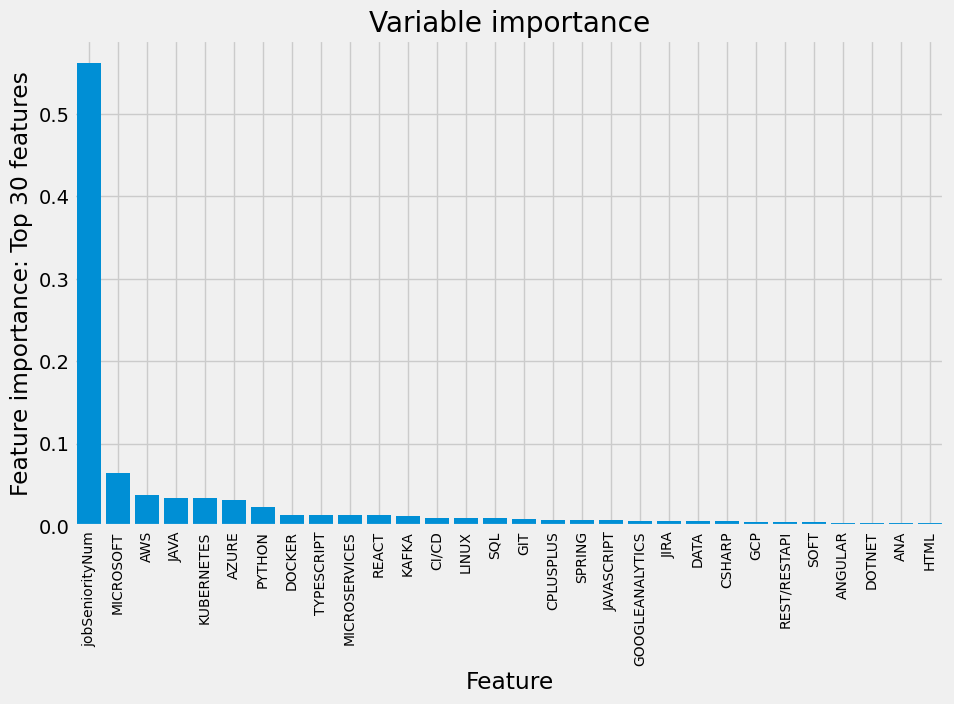

In [ ]:
param_grid = {
    'n_estimators': [1200], # number of boosting stages (higher - more complex)
    'max_depth': [13], # maximum depth of a single tree. The more = the more interactions, but overfit risk
    'learning_rate': [0.05], # how quickly trees contribute to ensemble. Higher values are faster to learn, but risk overfitting
    'min_samples_split': [2], # 0,5% of train dataset size: min samples needed to split an internal node
    'min_samples_leaf': [50], # Number required to be a leaf node 
    'max_features': [4,'sqrt',12,14,16,18,20,24,32] # number of features considered during each split
}
grid_search = tree_tuning('gbr',
                          factSkills_pivot_train_selected,
                          X_train_scaled,
                          y_train,
                          param_grid=param_grid,
                          verbose=0)
# No significant improvement over stage 1 in score


##### Selected gbr model

In [ ]:
gbr = GradientBoostingRegressor(n_estimators=1200,
                                max_depth=13,
                                learning_rate=0.05,
                                min_samples_split=2,
                                min_samples_leaf=50,
                                max_features=14)

gbr.fit(X_train_scaled,y_train)

GradientBoostingRegressor(learning_rate=0.05, max_depth=13, max_features=14,
                          min_samples_leaf=50, n_estimators=1200)

Final model is relatively complicated, so key is not to understand the performance on validation data set

### Validation on uninvolved data set

In [ ]:
y_pred_lr = lr.predict(X_val_scaled)
y_pred_gbr = gbr.predict(X_val_scaled)
y_pred_rfr = rfr.predict(X_val_scaled)

r2_l2 = r2_score(y_val, y_pred_lr)
r2_gbr = r2_score(y_val, y_pred_gbr)
r2_rfr = r2_score(y_val, y_pred_rfr)

mse_lr = mean_squared_error(y_val,y_pred_lr)
mse_gbr = mean_squared_error(y_val,y_pred_gbr)
mse_rfr = mean_squared_error(y_val, y_pred_rfr)

print(f'R2 Linear Reg = {round(r2_l2,5)} || R2 RF = {round(r2_rfr,5)} || R2 GBR = {round(r2_gbr,5)}')
print(f'MSE Linear Reg = {round(mse_lr,2)} || MSE RF = {round(mse_rfr,2)} || MSE GBR = {round(mse_gbr,2)}')

# Identifcal R2 for RF and GBR
# GBR slightly better than RFR in terms of MSE



R2 Linear Reg = 0.55699 || R2 RF = 0.59628 || R2 GBR = 0.5946
MSE Linear Reg = 28704096.67 || MSE RF = 26158092.78 || MSE GBR = 26267424.05


Nearly indentical performance of RFR and GBR. Linear regression lagging behind, but surprisingly good.
Key variable is seniority level, skills only add a flavour on top, thus such strong linearity.
RFR is chosen as model to test due to simplicity

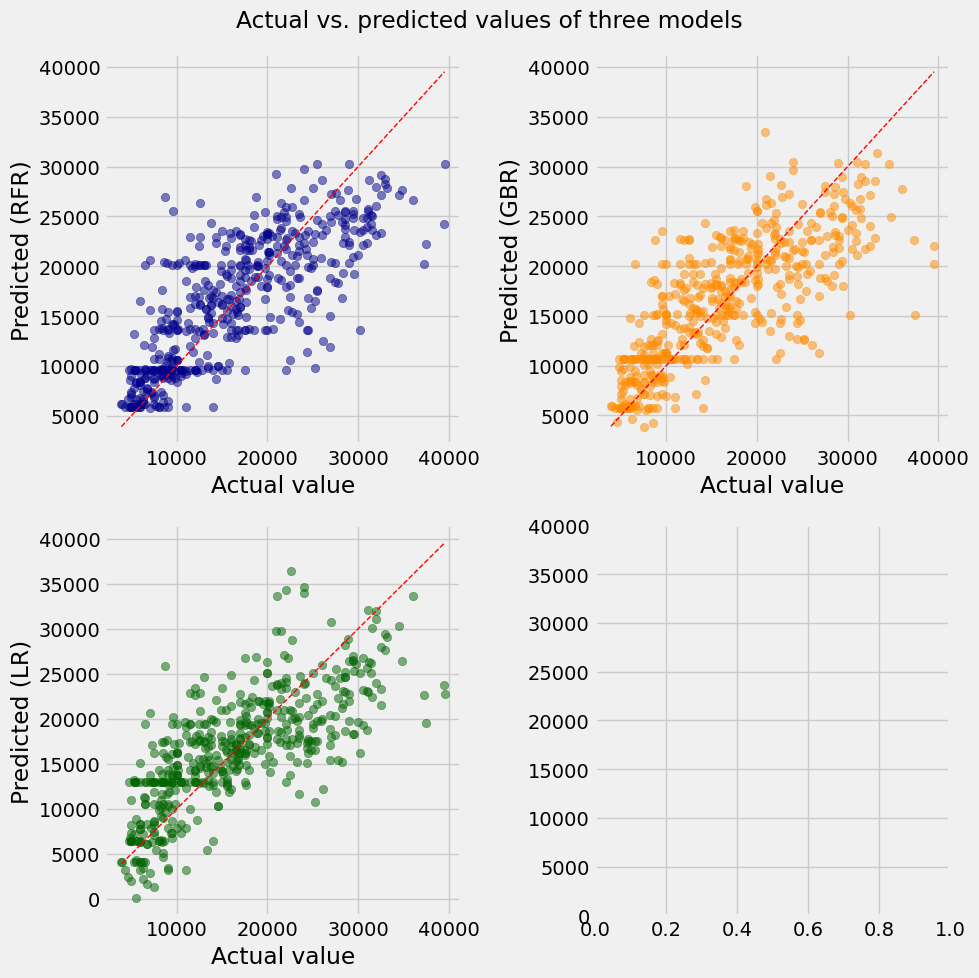

In [ ]:
fig, axes = plt.subplots(2,2, figsize=(10,10))


axes[0,0].scatter(y_val,y_pred_rfr, alpha=0.5, color='darkblue')
axes[0,0].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--',linewidth=1)
axes[0,0].set_xlabel("Actual value")
axes[0,0].set_ylabel("Predicted (RFR)")


axes[0,1].scatter(y_val,y_pred_gbr, alpha=0.5, color='darkorange')
axes[0,1].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--',linewidth=1)
axes[0,1].set_xlabel("Actual value")
axes[0,1].set_ylabel("Predicted (GBR)")


axes[1,0].scatter(y_val,y_pred_lr, alpha=0.5, color='darkgreen')
axes[1,0].set_xlabel("Actual value")
axes[1,0].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--',linewidth=1)
axes[1,0].set_ylabel("Predicted (LR)")



fig.suptitle('Actual vs. predicted values of three models')
plt.ylim(0,40000)

plt.tight_layout()

plt.show()
# Higher salaries are under-valued, especially with LR. Tree does slightly better

##### Saving model

In [ ]:
joblib.dump(rfr,'model.pkl') # Save final model to pickle

['model.pkl']

## 7. TESTING

Testing model on unseen dataset

#### Staging test data


##### Importing data

In [ ]:
model = joblib.load('model.pkl') # Load final model

In [ ]:
factSkills_pivot_test = pd.read_pickle('X_test.pkl') # Test, unseen data
with open('y_test.pkl','rb') as file:
    salaryMean_test = pickle.load(file) # Salary Mean (y)

lower_upper_bounds = pd.read_pickle('lower_upper_bound.pkl') # Lower / upper bounds for jobSeniorityNum
scaler = load('standard_scaler.pkl') # Standard scaler performed on train data
with open('selected_features.pkl','rb') as file:
    selected_features = pickle.load(file) # List of selected features


# MOVE TO TEST
factSkills_pivot_test,salaryMean_test, seniority_levels_test_df = prepare_pivoted_dataSet(factSkills_pivot_test)


##### Outlier removal based on train criteria

In [ ]:
# TRANSFORMATION 1 - trim salary based on train/val histogram outlier data
factSkills_pivot_test, salaryMean_test = t1_trim_total_salary_range(
    factSkills_pivot_test,
    salaryMean_test,
    2000,
    50000)

In [ ]:
# TRANSFORMATION 2 - trim salary based on 3sigma outlier per job seniority
factSkills_pivot_test, salaryMean_test = t2_trim_salary_per_seniority(factSkills_pivot_test, salaryMean_test, lower_upper_bounds)
factSkills_pivot_test = factSkills_pivot_test.fillna(0) # In case some skill is completely missing


4 rows removed


##### Split dataset into skills and categories

In [ ]:
# Separate skills from categories
factSkills_pivot_test_skills = factSkills_pivot_test.drop(columns=jobCategories,axis=1)
factSkills_pivot_test_categories = factSkills_pivot_test[jobCategories]

# put column categories as single column pd series
factSkills_pivot_test_categories = single_column_categories(factSkills_pivot_test_categories)

# Recode categories to category segments
factSkills_pivot_test = recode_categories_to_segments(factSkills_pivot_test_skills,
                                                      factSkills_pivot_test_categories)
# Leave only skills to modelling
factSkill_pivot_test = factSkills_pivot_test_skills

#### Variable selection and scaling

In [ ]:
# Sort vars by name
# Choose only variables relevant during training
factSkills_pivot_test_selected = factSkills_pivot_test[allvars]
factSkills_pivot_test_selected = factSkills_pivot_test_selected.sort_index(axis=1)

X_test_scaled = scaler.transform(factSkills_pivot_test_selected)
y_test = salaryMean_test # Reference as y_test

### Predictions on test set

In [ ]:
y_test_pred = model.predict(X_test_scaled) # Predit on test data

In [ ]:
mse = mean_squared_error(y_test, y_test_pred)

r2 = r2_score(y_test,y_test_pred)

mse=15569709.77095566, me=3945.8471550423315, r2=0.76052016834245


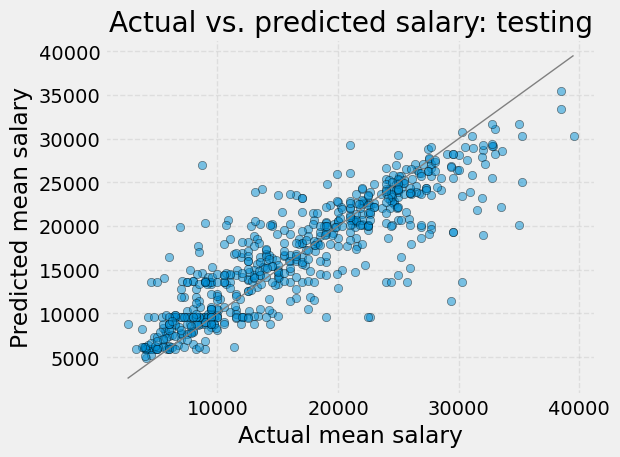

In [ ]:
print(f'mse={mse}, me={mse**(1/2)}, r2={r2}') # Error of 4K PLN on average, not much worse than val set, no apparent overfitting
plt.scatter(y_test, y_test_pred,alpha=0.5, edgecolors='k') # Linear realationship to most extent
plt.xlabel('Actual mean salary')
plt.ylabel('Predicted mean salary')
plt.grid(True, linestyle='--', alpha=0.5)
plt.title('Actual vs. predicted salary: testing')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='grey', linestyle='-', linewidth=1)
plt.tight_layout()
plt.show()


The model accuracy is sufficient to proceed further. Approx 4K mean salary error is acceptable

### Data merge


In [ ]:
factSkills_pivot_trainval = pd.read_pickle('factSkills_pivot_trainval_cleaned.pkl')
salaryMean_trainval = pd.read_pickle('salaryMean_trainval_cleaned.pkl')

In [ ]:
factSkills_pivot = pd.concat([factSkills_pivot_trainval,factSkills_pivot_test],axis=0)
salaryMean = pd.concat([salaryMean_trainval,salaryMean_test],axis=0)
factSkills_pivot = factSkills_pivot.sort_index(axis=1)
factSkills_pivot.to_pickle('factSkills_pivot_all_final.pkl')
salaryMean.to_pickle('salaryMean_all_final.pkl')

## 8. ANALYSIS AND SIMULATION - JOB SKILL RECOMMENDER

In [74]:
class JobSkillRecommender():
    def __init__(self, df, 
                 model = None, 
                 scaler = None,
                 job_categories = None,
                 selected_category = None):
        self.df = df # Data frame
        ## CALCULATE STARTING SIZE OF JOB DF
        self.model = model # Model
        self.scaler = scaler # Standard scaler
        self.job_categories = pd.DataFrame({'job_categories': job_categories})
        # If single category analysis, perform df subsettting
        if selected_category:
            # Trim the job data to only selected categories
            self.job_categories = self.job_categories[self.job_categories['job_categories'].isin(selected_category)]

            # Perform similar selection on skill df
            self.df = self.df.loc[self.job_categories.index]
        # Skills separate dataset

        self.numberOfJobs = len(self.df) # Number of jobs (denominator)

        
    def calculateReach(self,usr_skills):
        '''
        Calculates reach based on input skill
        Reach = (number of fitting jobs) / (total number of jobs)
        '''
        # Subset db of other skills
        oth_skills_df = self.df_matched.drop(columns=usr_skills) # Keep other skills
        
        # Subset db of user skills
        usr_skills_df = self.df_matched[usr_skills] # Keep these skills

        # Sum of needed other skills
        c2_other_skills = oth_skills_df.sum(axis=1) # How many other skills needed
        
        # Sum of needed user skills
        c2_matched_skills = usr_skills_df.sum(axis=1) # How many owned skills needed

        # If matched skills > other skills, we assume job fits the user
        
        rch = sum(c2_matched_skills > c2_other_skills) / self.numberOfJobs
        return rch
    
    def get_expected_salary(self, user_seniority, user_skills):
        '''
        Accepts seniority level and user skills to predict expected salary
        '''
      
        input_values = {} #Empty dict
          
        # user seniority (values 1 to 9)
        input_values['jobSeniorityNum'] = [user_seniority]
        
        # for every skill in user_skills, add to dictionary and assign 1
        for skill in user_skills:
            input_values[skill] = [1]
            
        # every col in df, if col is not present in input values, assign 0 to it
        for col in self.df.columns:
            if col not in input_values:
                input_values[col] = 0

        # build tmp_df as 1-row df
        tmp_df = pd.DataFrame(input_values)
        tmp_df = tmp_df.sort_index(axis=1)
        #tmp_df = tmp_df[self.skills_shortlist] 
        # tmp_df = tmp_df.values
        new_data_scaled = self.scaler.transform(tmp_df)
        input_predict = self.model.predict(new_data_scaled)
        return round(input_predict[0],2)

    def predict_skill_impact_on_salary(self):
        '''
        predicts unit skill impact on salary and returns a data frame
        '''
        skills = [] # Empty skills array
        salaries = [] # Emmpty salary array
        
        # For every skill in df (without seniority level)
        for skill in self.df.drop(['jobSeniorityNum'],axis=1).columns:
            skills.append(skill) # Add skill to analysis
            # Use method to calculate the salary for this only skill
            salaries.append(self.get_expected_salary(self.user_seniority,
                                                  [skill]))
        
        # Obtain a df
        skill_salaries_df = pd.DataFrame({'skill':skills,
                                         'salary': salaries})

        return skill_salaries_df
    
    def gatherUserInput(self, user_seniority, user_skills):
        '''
        Gets users' input (seniority and jobs).
        Calculates starting reach and salary (if with model)
        '''
        # Assign values to user seniority and skills
        self.user_seniority = user_seniority 
        self.user_skills = user_skills
        
        # Condition 1 - job seniority must be equal or lower
        self.df_matched = self.df.query(' jobSeniorityNum <= @user_seniority')
        self.df_matched = self.df_matched.drop(columns=['jobSeniorityNum'])
        
        # Assign user skills and obtain remanining skills
        self.other_skills_df = self.df_matched.drop(columns=user_skills)
        self.user_skills_df = self.df_matched[user_skills]
        
        # Calculate starting reach
        self.starting_reach = self.calculateReach(self.user_skills)
        self.reach = self.starting_reach
        
        print(f'Starting reach: {self.starting_reach}')
        print(f'Starting salary: {self.get_expected_salary(self.user_seniority,self.user_skills)}')
        
    def print_reach(self):
        '''
        Prints reach of the current reach calculation
        '''
        print(f'Reach = {round(self.rch*100,1)}%')
        
    def findNextSkill(self):
        '''
        Checks all the other skills. 
        Returns a data frame with the ones that deliver highest reach incremental
        '''
        # N+1 skill browser
        # Starting reach array
        reach_array = [self.starting_reach] # Starting reach
        salary_array = [self.get_expected_salary(self.user_seniority,self.user_skills)]
        
        # Starting jobs array
        jobs_array = ['your_jobs']
        
        # For every item in other items' columns
        for i in self.other_skills_df.columns:
            # Append for new skill
            user_skills_new = self.user_skills + [i]
            # Calculate reach and expected salary for extended skillset
            reach = self.calculateReach(user_skills_new)
            salary = self.get_expected_salary(self.user_seniority,user_skills_new)

            # Append corresponding arrays
            reach_array = reach_array + [reach]
            jobs_array = jobs_array + [i]
            salary_array = salary_array + [salary]

        # Build a data frame
        jobs_reach_df = pd.DataFrame({"job": jobs_array, 
                                      "reach": reach_array,
                                     "salary": salary_array})
        
        # Calculate incremental against the base scenario
        jobs_reach_df['incremental'] = jobs_reach_df['reach'] - jobs_reach_df.loc[0, 'reach']
        
        # Leave out only skills that deliver any incremental
        jobs_reach_df = jobs_reach_df.query('incremental > 0 ')
        jobs_reach_df = jobs_reach_df.reset_index(drop=True)
        # Charting
        fig = plt.figure(figsize=(10,10))
        
        # Ensure optimal layout to many points
        plt.tight_layout()
        
        # Run a scatter method
        plt.scatter(jobs_reach_df['reach'], jobs_reach_df['salary'],alpha=0.5)
        
        # Fetch texts to labels
        texts = [] 
        for i, label in enumerate(jobs_reach_df['job']):
            texts.append(plt.text(jobs_reach_df['reach'][i], 
                                  jobs_reach_df['salary'][i],
                                  label, fontsize=8))
        adjust_text(texts)
        
        # Other formatting
        plt.xlabel('Reach after skill is introduced')
        plt.ylabel('Expected salary after skill is introduced')
        plt.grid(False)

        plt.show()
        
        # Return a table of most optimal jobs to add to the current skill set
        return jobs_reach_df.sort_values(by='reach',ascending=False)
          
    def careerPath(self,max_portfolio_size=30):
        '''
        Finds optimal in terms of reach building career path, 
        by adding one skill after another which are most optimal at the given stop
        max_portfolio_size (int) - maximum number of skills to be added to portfolio (default 30)
        '''
        
        check = 0 # Start checker at 0
        
        # Starting jobs array
        jobs_array = self.user_skills
        
        # Starting reach array
        reach_array = [self.starting_reach]*len(jobs_array) # Starting reach
        
        # While there are other skills to investigate and iteration is below max size
        while len(self.other_skills_df.columns)>0 and check <= max_portfolio_size:
            # Number of iterations = skills left to analyse
            tmp_reach = 0 # Set starting reach to 0
            tmp_index = None # Set index to none
            
            # For every i and skill column in dataframe columns
            for i, skill_column in enumerate(self.other_skills_df.columns):
                user_skills_new = self.user_skills + [skill_column]
                
                # Get Reach
                r = self.calculateReach(user_skills_new)
                
                # If reach greater than value stored so far, replace it
                if r > 0 and r > tmp_reach:
                    tmp_reach = r
                    tmp_index = i
            
            # If tmp_index is negative, stop the loop
            if tmp_index == -1:
                break
            
            # Assign the most optimal result to the user array
            self.user_skills = self.user_skills + [self.other_skills_df.columns[tmp_index]]
            job_array = jobs_array + [self.other_skills_df.columns[tmp_index]]
            reach_array = reach_array + [tmp_reach]                        
            self.other_skills_df = self.other_skills_df.drop(self.other_skills_df.columns[tmp_index], axis=1)

            # Go to the next skill to be added if there is still room
            check += + 1 # Increment check
        
        # Build a dataframe out of skills and reach
        jobs_reach_df = pd.DataFrame({"skill": self.user_skills, "reach": reach_array})
        # Calculate incremental
        jobs_reach_df['incremental'] = jobs_reach_df['reach'].diff().fillna(0)
        
        # PLOTTING OF REACH AND INCREMENTAL
        # Set up a bigg plot area and tight layout
        fig = plt.figure(figsize=(10,6))
        plt.tight_layout()
        
        # Add line plot to reflect reach frowth
        sns.lineplot(x='skill', y='reach', data=jobs_reach_df, color='blue')
        # Add barplot to reflect incremental at the given step
        sns.barplot(x='skill',y='incremental',data=jobs_reach_df,color='green')

        # Get skill names as labels, rotate vertically
        plt.xticks(jobs_reach_df.index,'+' + jobs_reach_df['skill'])
        plt.xticks(rotation='vertical')
        
        # Further formatting
        plt.title('Optimal order of skill development')
        plt.xlabel('+Skill -->')
        plt.ylabel('% of jobs qualified / incremental')
        
        # Add color legend
        blue_patch = plt.Line2D([], [], color='blue', label='Reach')
        green_patch = plt.Line2D([], [], color='green', label='Incremental')
        plt.legend(handles=[blue_patch, green_patch])

        # Return dataframe for further processing
        return jobs_reach_df
    
    def skill_optimizer(self,must_have_skills='user_skills', k=3, iterations=100):
        '''
        depicts an nearly optimal combination of skills to achieve better salaries
        skills are drawn with a probability 
        algorithm limited to make iterations, as searching the full space would take very long as it is done by nCr
        '''
        # Initial prediction of stand-alone skills that will server as weights for probability
        # skills = skill_weight_df['skill'].tolist()
        skill_weight_df = self.predict_skill_impact_on_salary()
        # weights = skill_weight_df['salary'].tolist()
        
        # Starting arrays
        optimal_combinations_skills = [] 
        optimal_combinations_salary = [] 
        optimal_combinations_reach = []

        if must_have_skills== 'user_skills':
            selected_skills = self.user_skills
        elif must_have_skills is not None:
            selected_skills = must_have_skills
        else:
            selected_skills = []

        skill_weight_df = skill_weight_df[~skill_weight_df['skill'].isin(selected_skills)]
        skills = skill_weight_df['skill'].tolist()
        weights = skill_weight_df['salary'].tolist()
        #skills = list(set(skills) - set(selected_skills))

        scenarios=[]
        counter = 0
        # While iteration is lower that agreed number of iterations
        while counter <= 10:
            # Set up a skill set
            skill_set = set()

            # Set up sample
            sample = []
            # While draws are lower than k
            while len(sample) < k:
                # Random choice, weighten, with replacement
                choice = random.choices(skills,weights)[0]
                # If choce is not already on skill set, append skill_set and sample
                if choice not in skill_set:
                    skill_set.add(choice)
                    sample.append(choice)
            
            # if the drawn sample is not already in scenarios then add to the sample
            if sorted(sample) not in scenarios:
                scenarios.append(sorted(sample))
                counter += 1

        for scenario in scenarios:

            # Build a skill list
            skills_to_simulate = selected_skills + scenario
            # Predict salary for skill set
            predicted_salary = self.get_expected_salary(self.user_seniority, skills_to_simulate)
            # Calculate reach
            selected_reach = self.calculateReach(skills_to_simulate)

            # Append all three arrays
            optimal_combinations_skills.append([skills_to_simulate])
            optimal_combinations_salary.append(predicted_salary)
            optimal_combinations_reach.append(selected_reach)

        # Make a dataframe
        optimal_combinations_df = pd.DataFrame({
            'skills': optimal_combinations_skills,
            'salary': optimal_combinations_salary,
            'reach': optimal_combinations_reach
        })

        # Calculate value potential that is a multiplication of salary level and reach
        optimal_combinations_df['value_potential'] = optimal_combinations_df['salary'] * optimal_combinations_df['reach']
        
        # Sort df by value potential (desc)
        optimal_combinations_df = optimal_combinations_df.sort_values(by='value_potential',
                                                                     ascending=False)
        return optimal_combinations_df          
    
    

        

#### Data and model imports

In [4]:
model = joblib.load('model.pkl') # GBR model
scaler = joblib.load('standard_scaler.pkl') # Standard scaler
# Selected features
with open('selected_features.pkl', 'rb') as file:
    selected_features = pickle.load(file) 

# Data frame
factSkills_pivot = pd.read_pickle('factSkills_pivot_all_final.pkl')

# Single out categories
categoriesAgr = single_column_categories(factSkills_pivot.filter(regex='^cat'))
factSkills_pivot = factSkills_pivot.loc[:, ~factSkills_pivot.columns.str.startswith('cat')]
factSkills_pivot_selected = factSkills_pivot[selected_features]




#### Gather user input

ACCEPTS USER DATA AND PRINTS REACH (number of jobs with matching requirements) and expected salary as modelled <br>
Enter seniority level (1-trainee, 2- trainee-junnior, 3-junior, 5-mid, 6 - mid-senior, 7 - senior, 8 - senior-expert, 9 - expert)<br>
Enter category segment

In [75]:
categories = ['cat: DESIGN MOBILE',	'cat: IT ADMIN SUPPORT SECURITY',
            'cat: MARKETING',	'cat: AGILE TESTING',
            'cat: GAME DEV', 'cat: BACKOFFICE HR SALES', 'cat: EMBEDDED ERP'
            'cat: BI BIG DATA AI',	'cat: DEV OPS'	'cat: DEVELOPMENT'	
            'cat: BA PROD PROJECT MANAGER']
											
# In Array, enter skills, capitalized. Consult selected_features for available major skills
seniority_level = 6
selected_category = ['cat: BI BIG DATA AI']
skills = ['SQL','MICROSOFT','PYTHON']


Initialize the class


In [76]:
reco = JobSkillRecommender(df=factSkills_pivot_selected,
                           model=model,
                           scaler=scaler,
                           job_categories = categoriesAgr,
                           selected_category=selected_category)

Gather user input, calculate starting reach and expected salary

In [77]:
reco.gatherUserInput(user_seniority=seniority_level,
                    user_skills=skills)


Starting reach: 0.09392265193370165
Starting salary: 13685.74


Find next skill to learn

BASED ON CURRENT SKILL PORTFOLIO, TESTS HOW MUCH GIVEN SKILL COULD IMPROVE REACH AND SALARY


In [60]:
#reco.findNextSkill()

#### Skill recommender - based on modelled salary mean and reach of particular skill combination

Key algorithm. Based on the specified number, search for relatively more optimal skill combination that balance high skill salary with good reach<br>
For now, even importance of salary and reach<br>
Parameters:<br>
- k - number of skills to search for<br>
- iterations - number of iteration. Full search would require nCr combinations, with approx 85 skills as a search space. This should require significant computational power<br>
- Therefore, algorithm can be limited to iteration.

In [78]:
# TODO - weighting by salary impact and reach. User fixed skills
reco.skill_optimizer(must_have_skills=['SQL','JAVA'], k=1, iterations=2)

,skills,salary,reach,value_potential
9,"[[SQL, JAVA, GOOGLECLOUD]]",22929.25,0.033149,760.085635
0,"[[SQL, JAVA, AZURE]]",21910.68,0.033149,726.320884
2,"[[SQL, JAVA, REDIS]]",20356.70,0.033149,674.807735
5,"[[SQL, JAVA, POWERSHELL]]",20034.18,0.033149,664.116464
10,"[[SQL, JAVA, PYTHON]]",19858.45,0.033149,658.291160
8,"[[SQL, JAVA, SLACK]]",19803.17,0.033149,656.458674
7,"[[SQL, JAVA, CRM]]",19588.45,0.033149,649.340884
1,"[[SQL, JAVA, SEO]]",19467.50,0.033149,645.331492
6,"[[SQL, JAVA, DOCKER]]",19383.85,0.033149,642.558564
3,"[[SQL, JAVA, GOOGLEADS]]",19316.00,0.033149,640.309392


#### Find an optimal career path to optimize reach

Analysis purely based on reach. Aim is to maximise reach as an extension to user input skills. <br>

,skill,reach,incremental
0,SQL,0.093923,0.000000
1,MICROSOFT,0.093923,0.000000
2,PYTHON,0.093923,0.000000
3,AZURE,0.127072,0.033149
4,ETL,0.171271,0.044199
5,DATA,0.215470,0.044199
6,CLOUD,0.237569,0.022099
7,SPARK,0.259669,0.022099
8,SCALA,0.298343,0.038674
9,ANA,0.314917,0.016575


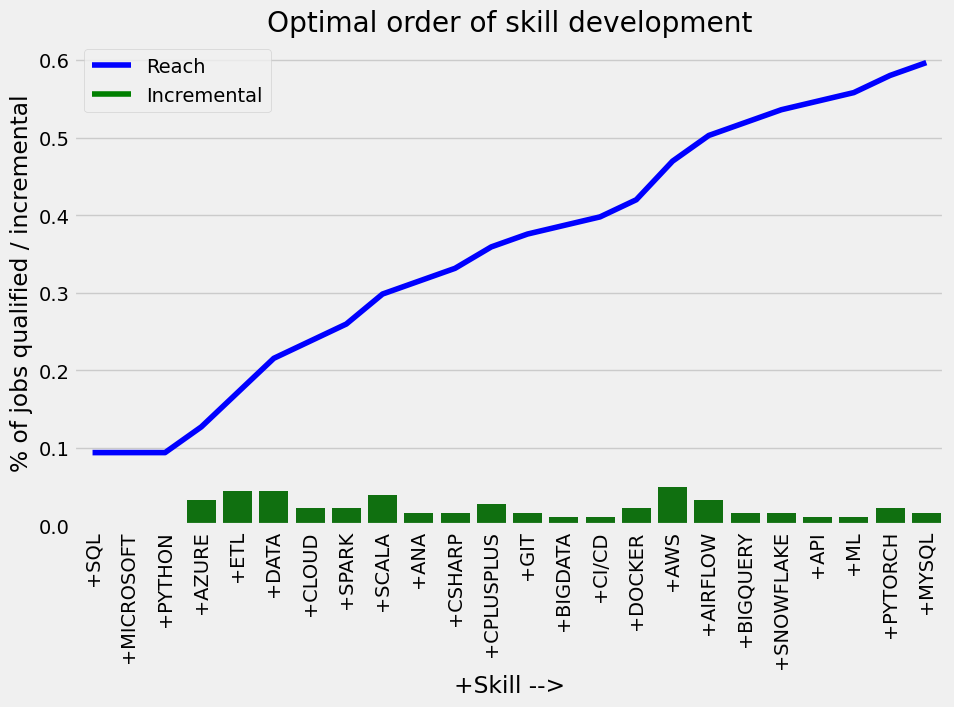

In [10]:
reco.careerPath(max_portfolio_size=20)

In [69]:
reco.predict_skill_impact_on_salary()

,skill,salary
0,AIRFLOW,13754.86
1,AKKA,13603.52
2,ANA,19830.69
3,ANGULAR,14778.57
4,ANSIBLE,14385.87
...,...,...
107,UNIX,16191.06
108,VUEDOTJS,13647.53
109,WEBPACK,14627.47
110,WEBSERVICES,13603.52
